In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics.scorer import make_scorer
%matplotlib inline


from sklearn.datasets import make_blobs
from sklearn.cluster import MeanShift, estimate_bandwidth
from scipy.spatial.distance import cdist 

from sklearn.cluster import KMeans
from datetime import datetime

In [2]:
from google.colab import files

ImportError: No module named 'google.colab'

In [3]:
#Upload train and val label data set file from local to colabs area
uploaded = files.upload()

Saving train.txt to train.txt


In [2]:
# Load Train and val label dataset
train_df = pd.read_fwf("train.txt", sep=" ", header=None)
#train_df.reset_index()
train_df.head(5).append(train_df.tail(5))

,0,1
0,1278160345,"962\tFriday\t20\t39,8851194\t32,8562758\t39,87..."
1,1274461376,"916\tTuesday\t8\t39,8834635\t32,8335031\t39,89..."
2,1278402853,"1175\tSaturday\t2\t39,9164664\t32,7246981\t39,..."
3,1272398564,"1630\tSaturday\t15\t39,93071844\t32,61985895\t..."
4,1279996323,"561\tSunday\t18\t39,914876\t32,72881434\t39,93..."
178085,1271716250,"328\tFriday\t20\t39,89996651\t32,75756675\t39,..."
178086,1275289045,"842\tWednesday\t6\t39,87718115\t32,81464391\t3..."
178087,1269676370,"517\tWednesday\t19\t39,7956454\t32,8746088\t39..."
178088,1273331688,"797\tSunday\t18\t39,8658282\t32,8524761\t39,88..."
178089,1291915508,"919\tSunday\t0\t39,9457001\t32,7596329\t39,954..."


In [3]:
train_df.shape

(178090, 2)

In [4]:
split_data = train_df[1].str.split("\t")
data = split_data.to_list()
names = ["travel_time", "travel_day", "travel_hour", "source_latitute", "source_longitute", "destination_latitute", "destination_longitute"]
new_df = pd.DataFrame(data, columns=names)
new_df.head(5)

,travel_time,travel_day,travel_hour,source_latitute,source_longitute,destination_latitute,destination_longitute
0,962,Friday,20,"39,8851194","32,8562758","39,8718379","32,8222507"
1,916,Tuesday,8,"39,8834635","32,8335031","39,8912282","32,85792586"
2,1175,Saturday,2,"39,9164664","32,7246981","39,9414644","32,7183841"
3,1630,Saturday,15,"39,93071844","32,61985895","39,9023246","32,5240639"
4,561,Sunday,18,"39,914876","32,72881434","39,9307344","32,7187225"


In [5]:
new_df.shape

(178090, 7)

In [6]:
train_df.rename(columns={0: "travel_id"}, inplace= True)
train_df = train_df.drop(columns=[1])
train_df.head(5)

,travel_id
0,1278160345
1,1274461376
2,1278402853
3,1272398564
4,1279996323


In [7]:
train_df.shape

(178090, 1)

In [8]:
train_df = pd.concat([train_df, new_df], axis=1)

In [9]:
train_df.head(5).append(train_df.tail(5))

,travel_id,travel_time,travel_day,travel_hour,source_latitute,source_longitute,destination_latitute,destination_longitute
0,1278160345,962,Friday,20,"39,8851194","32,8562758","39,8718379","32,8222507"
1,1274461376,916,Tuesday,8,"39,8834635","32,8335031","39,8912282","32,85792586"
2,1278402853,1175,Saturday,2,"39,9164664","32,7246981","39,9414644","32,7183841"
3,1272398564,1630,Saturday,15,"39,93071844","32,61985895","39,9023246","32,5240639"
4,1279996323,561,Sunday,18,"39,914876","32,72881434","39,9307344","32,7187225"
178085,1271716250,328,Friday,20,"39,89996651","32,75756675","39,8954665","32,7700688"
178086,1275289045,842,Wednesday,6,"39,87718115","32,81464391","39,89683446","32,81631269"
178087,1269676370,517,Wednesday,19,"39,7956454","32,8746088","39,80247745","32,88210816"
178088,1273331688,797,Sunday,18,"39,8658282","32,8524761","39,8884061","32,8780075"
178089,1291915508,919,Sunday,0,"39,9457001","32,7596329","39,9541224","32,7690627"


In [10]:
# https://stackoverflow.com/a/18364570
def get_columns_bins(column_name):
  all_bins = []
  
  for method in bins_methods:
    start = datetime.now()
    hist, bin_edges = np.histogram(column_name,bins=method)
    all_bins.append(bin_edges)
    print("Method : {:<7} - Running Time : {:<5} - Number of bins : {:<5} - Head : {} - Tail : {}".format(method,str(datetime.now()-start), len(bin_edges), bin_edges[:3], bin_edges[-3:-1]))
  return all_bins

In [11]:
# https://stackoverflow.com/a/18364570
def get_clustering_bins(s, quantile=0.3, n_samples=None):
    
    series = s.dropna().values.reshape(-1, 1)
    
    bandwidth = estimate_bandwidth(series, quantile=quantile, n_samples=n_samples)
    clustering = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(series)

    d = pd.DataFrame(columns=['data_column', 'label_column'])

    d['data_column'] = series.reshape(-1)
    d['label_column'] = clustering.labels_
    
    sorted_vals = d.groupby('label_column')['data_column'].max().sort_values().values
    bins = np.insert(sorted_vals, [0] , [series.min()-1])
    bins[-1] = bins[-1] + 1
    
    return bins, range(bins.size-1) 

In [12]:
bins_methods = [ "auto", "fd", "doane", "scott", "stone", "rice", "sturges", "sqrt"]

In [13]:
train_df.dtypes

travel_id                 int64
travel_time              object
travel_day               object
travel_hour              object
source_latitute          object
source_longitute         object
destination_latitute     object
destination_longitute    object
dtype: object

In [14]:
train_df.source_latitute.values

array(['39,8851194', '39,8834635', '39,9164664', ..., '39,7956454',
       '39,8658282', '39,9457001'], dtype=object)

In [15]:
train_df.source_latitute.isnull

<bound method Series.isnull of 0          39,8851194
1          39,8834635
2          39,9164664
3         39,93071844
4           39,914876
5         39,87322332
6         39,94181921
7         39,93340017
8          39,8691594
9          39,8512194
10        39,91245748
11         39,8714276
12         39,8679657
13         39,8761694
14        39,84750463
15         39,9035535
16         39,9554503
17        39,87723771
18        39,85516073
19        39,91525747
20        39,91671469
21         39,8702774
22         39,9425394
23         39,7928095
24         39,8593394
25        39,83617117
26         39,9081444
27        39,85656836
28         39,9307144
29        39,86716558
             ...     
178060    39,93533572
178061    39,84406961
178062    39,85779669
178063    39,84971716
178064    39,82500174
178065     39,9547324
178066      39,857586
178067    39,89383795
178068     39,9007294
178069     39,9307337
178070    39,87608435
178071    39,87533285
178072    39,89609625
1

In [16]:
train_df['source_latitute'].values

array(['39,8851194', '39,8834635', '39,9164664', ..., '39,7956454',
       '39,8658282', '39,9457001'], dtype=object)

In [17]:
train_df['travel_day'].values

array(['Friday', 'Tuesday', 'Saturday', ..., 'Wednesday', 'Sunday',
       'Sunday'], dtype=object)

In [18]:
train_df['source_latitute'] = train_df['source_latitute'].str.replace(',','.')
train_df['source_latitute'].values

array(['39.8851194', '39.8834635', '39.9164664', ..., '39.7956454',
       '39.8658282', '39.9457001'], dtype=object)

In [19]:
#train_df.source_latitute = np.array(train_df.source_latitute, dtype=float)
train_df['source_latitute'] = train_df['source_latitute'].astype(float)

In [20]:
train_df.dtypes

travel_id                  int64
travel_time               object
travel_day                object
travel_hour               object
source_latitute          float64
source_longitute          object
destination_latitute      object
destination_longitute     object
dtype: object

In [21]:
all_bins_source_latitude = []
all_bins_source_latitude = get_columns_bins(train_df.source_latitute)

Method : auto    - Running Time : 0:00:00.008822 - Number of bins : 584   - Head : [38.7160794  38.71846058 38.72084176] - Tail : [40.09954388 40.10192506]
Method : fd      - Running Time : 0:00:00.004386 - Number of bins : 584   - Head : [38.7160794  38.71846058 38.72084176] - Tail : [40.09954388 40.10192506]
Method : doane   - Running Time : 0:00:00.013332 - Number of bins : 30    - Head : [38.7160794  38.76394929 38.81181918] - Tail : [40.00856646 40.05643635]
Method : scott   - Running Time : 0:00:00.002421 - Number of bins : 257   - Head : [38.7160794  38.72150216 38.72692492] - Tail : [40.09346072 40.09888348]
Method : stone   - Running Time : 0:00:00.668153 - Number of bins : 394   - Head : [38.7160794  38.71961178 38.72314417] - Tail : [40.09724147 40.10077386]
Method : rice    - Running Time : 0:00:00.002312 - Number of bins : 114   - Head : [38.7160794  38.72836459 38.74064979] - Tail : [40.07973585 40.09202105]
Method : sturges - Running Time : 0:00:00.002186 - Number of bin

array([37.7160794 , 38.7708465 , 38.83037595, 38.89466776, 38.95895957,
       39.02325138, 39.08754319, 39.15183499, 39.2161268 , 39.28041861,
       39.34471042, 39.40900223, 39.47329404, 39.53758585, 39.60187766,
       39.66616947, 39.73046128, 39.79475309, 39.85904489, 39.9233367 ,
       39.98762851, 40.04477679, 41.10430624])

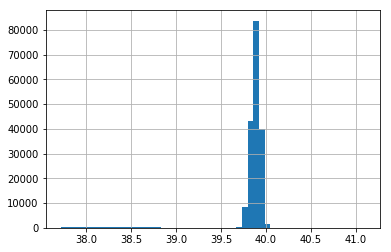

In [22]:
source_latitude_bin,label = get_clustering_bins(pd.Series(all_bins_source_latitude[0]), quantile=0.1, n_samples=20)
train_df.source_latitute.hist(bins=source_latitude_bin)
source_latitude_bin

In [23]:
len(source_latitude_bin) , train_df.source_latitute.value_counts(bins=source_latitude_bin)


(23, (39.859, 39.923]    83692
 (39.795, 39.859]    43317
 (39.923, 39.988]    39973
 (39.73, 39.795]      8489
 (39.988, 40.045]     1452
 (38.771, 38.83]       445
 (39.666, 39.73]       335
 (37.715, 38.771]      255
 (38.83, 38.895]        90
 (40.045, 41.104]       38
 (38.959, 39.023]        2
 (38.895, 38.959]        2
 (39.409, 39.473]        0
 (39.473, 39.538]        0
 (39.28, 39.345]         0
 (39.216, 39.28]         0
 (39.152, 39.216]        0
 (39.088, 39.152]        0
 (39.023, 39.088]        0
 (39.538, 39.602]        0
 (39.602, 39.666]        0
 (39.345, 39.409]        0
 Name: source_latitute, dtype: int64)

In [24]:
train_df2 = train_df.copy()

In [25]:
train_df2['source_latitude_category'] = pd.cut(train_df2.source_latitute, source_latitude_bin).cat.codes
train_df2.head(5).append(train_df2.tail(5))

,travel_id,travel_time,travel_day,travel_hour,source_latitute,source_longitute,destination_latitute,destination_longitute,source_latitude_category
0,1278160345,962,Friday,20,39.885119,"32,8562758","39,8718379","32,8222507",18
1,1274461376,916,Tuesday,8,39.883463,"32,8335031","39,8912282","32,85792586",18
2,1278402853,1175,Saturday,2,39.916466,"32,7246981","39,9414644","32,7183841",18
3,1272398564,1630,Saturday,15,39.930718,"32,61985895","39,9023246","32,5240639",19
4,1279996323,561,Sunday,18,39.914876,"32,72881434","39,9307344","32,7187225",18
178085,1271716250,328,Friday,20,39.899967,"32,75756675","39,8954665","32,7700688",18
178086,1275289045,842,Wednesday,6,39.877181,"32,81464391","39,89683446","32,81631269",18
178087,1269676370,517,Wednesday,19,39.795645,"32,8746088","39,80247745","32,88210816",17
178088,1273331688,797,Sunday,18,39.865828,"32,8524761","39,8884061","32,8780075",18
178089,1291915508,919,Sunday,0,39.945700,"32,7596329","39,9541224","32,7690627",19


In [26]:
train_df['source_longitute'] = train_df['source_longitute'].str.replace(',','.')
train_df['source_longitute'].values

array(['32.8562758', '32.8335031', '32.7246981', ..., '32.8746088',
       '32.8524761', '32.7596329'], dtype=object)

In [27]:
train_df['source_longitute'] = train_df['source_longitute'].astype(float)

In [28]:
all_bins_source_longitute = []
all_bins_source_longitute = get_columns_bins(train_df.source_longitute)

Method : auto    - Running Time : 0:00:00.006628 - Number of bins : 1027  - Head : [32.4107515  32.41494927 32.41914704] - Tail : [36.70926844 36.71346621]
Method : fd      - Running Time : 0:00:00.005383 - Number of bins : 1027  - Head : [32.4107515  32.41494927 32.41914704] - Tail : [36.70926844 36.71346621]
Method : doane   - Running Time : 0:00:00.014107 - Number of bins : 31    - Head : [32.4107515  32.55431525 32.697879  ] - Tail : [36.43053648 36.57410023]
Method : scott   - Running Time : 0:00:00.003053 - Number of bins : 257   - Head : [32.4107515  32.42757538 32.44439925] - Tail : [36.68401623 36.7008401 ]
Method : stone   - Running Time : 0:00:00.690792 - Number of bins : 403   - Head : [32.4107515  32.42146521 32.43217893] - Tail : [36.69623655 36.70695027]
Method : rice    - Running Time : 0:00:00.002404 - Number of bins : 114   - Head : [32.4107515  32.44886577 32.48698004] - Tail : [36.64143544 36.67954971]
Method : sturges - Running Time : 0:00:00.002331 - Number of bin

array([31.4107515 , 32.47371806, 32.54088238, 32.63323333, 32.72138651,
       32.81373746, 32.90189064, 32.97325274, 33.06560369, 33.15375687,
       33.24610782, 33.334261  , 33.42661195, 33.51476513, 33.58612723,
       33.67847818, 33.76663135, 33.8589823 , 33.94713548, 34.01849758,
       34.11084853, 34.19900171, 34.29135266, 34.37950584, 34.45086794,
       34.54321889, 34.63137207, 34.72372302, 34.8118762 , 34.90422715,
       34.99238033, 35.06374242, 35.15609337, 35.24424655, 35.3365975 ,
       35.42475068, 35.49611278, 35.58846373, 35.67661691, 35.76896786,
       35.85712104, 35.94947199, 36.03762517, 36.10898726, 36.20133821,
       36.28949139, 36.38184234, 36.46999552, 36.54135762, 36.6295108 ,
       37.71766398])

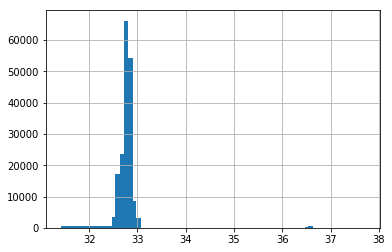

In [29]:
source_longitute_bin,label = get_clustering_bins(pd.Series(all_bins_source_longitute[0]), quantile=0.04, n_samples=70)
train_df.source_longitute.hist(bins=source_longitute_bin)
source_longitute_bin

In [30]:
len(source_longitute_bin) , train_df.source_longitute.value_counts(bins=source_longitute_bin)


(51, (32.721, 32.814]    66199
 (32.814, 32.902]    54396
 (32.633, 32.721]    23680
 (32.541, 32.633]    17168
 (32.902, 32.973]     8409
 (32.474, 32.541]     3591
 (32.973, 33.066]     3244
 (36.541, 36.63]       587
 (31.41, 32.474]       569
 (36.47, 36.541]       161
 (33.066, 33.154]       40
 (36.382, 36.47]        35
 (36.289, 36.382]        6
 (36.63, 37.718]         5
 (35.425, 35.496]        0
 (35.337, 35.425]        0
 (33.678, 33.767]        0
 (33.586, 33.678]        0
 (33.515, 33.586]        0
 (33.427, 33.515]        0
 (33.334, 33.427]        0
 (33.246, 33.334]        0
 (33.154, 33.246]        0
 (35.588, 35.677]        0
 (35.677, 35.769]        0
 (35.769, 35.857]        0
 (35.857, 35.949]        0
 (35.949, 36.038]        0
 (36.038, 36.109]        0
 (36.109, 36.201]        0
 (36.201, 36.289]        0
 (33.767, 33.859]        0
 (33.859, 33.947]        0
 (33.947, 34.018]        0
 (34.724, 34.812]        0
 (35.244, 35.337]        0
 (35.156, 35.244]       

In [31]:
train_df.source_longitute.isnull

<bound method Series.isnull of 0         32.856276
1         32.833503
2         32.724698
3         32.619859
4         32.728814
5         32.668740
6         32.620206
7         32.716455
8         32.596796
9         32.851746
10        32.759660
11        32.620008
12        32.758880
13        32.681606
14        32.852964
15        32.951991
16        32.751442
17        32.562232
18        32.771978
19        32.731979
20        32.591754
21        32.513084
22        32.728716
23        32.883924
24        32.846246
25        32.824796
26        32.544914
27        32.860282
28        32.621739
29        32.789422
            ...    
178060    32.794481
178061    32.787816
178062    32.811692
178063    32.770660
178064    32.832193
178065    32.727283
178066    32.831630
178067    32.770417
178068    32.817276
178069    32.639045
178070    32.796832
178071    32.592294
178072    32.734325
178073    32.598390
178074    32.826032
178075    32.805248
178076    32.591358
178077   

In [32]:
train_df.dtypes

travel_id                  int64
travel_time               object
travel_day                object
travel_hour               object
source_latitute          float64
source_longitute         float64
destination_latitute      object
destination_longitute     object
dtype: object

In [33]:
train_df2['source_longitute_category'] = pd.cut(train_df.source_longitute, source_longitute_bin).cat.codes
train_df2.head(5).append(train_df2.tail(5))

,travel_id,travel_time,travel_day,travel_hour,source_latitute,source_longitute,destination_latitute,destination_longitute,source_latitude_category,source_longitute_category
0,1278160345,962,Friday,20,39.885119,"32,8562758","39,8718379","32,8222507",18,5
1,1274461376,916,Tuesday,8,39.883463,"32,8335031","39,8912282","32,85792586",18,5
2,1278402853,1175,Saturday,2,39.916466,"32,7246981","39,9414644","32,7183841",18,4
3,1272398564,1630,Saturday,15,39.930718,"32,61985895","39,9023246","32,5240639",19,2
4,1279996323,561,Sunday,18,39.914876,"32,72881434","39,9307344","32,7187225",18,4
178085,1271716250,328,Friday,20,39.899967,"32,75756675","39,8954665","32,7700688",18,4
178086,1275289045,842,Wednesday,6,39.877181,"32,81464391","39,89683446","32,81631269",18,5
178087,1269676370,517,Wednesday,19,39.795645,"32,8746088","39,80247745","32,88210816",17,5
178088,1273331688,797,Sunday,18,39.865828,"32,8524761","39,8884061","32,8780075",18,5
178089,1291915508,919,Sunday,0,39.945700,"32,7596329","39,9541224","32,7690627",19,4


In [34]:
train_df['destination_latitute'] = train_df['destination_latitute'].str.replace(',','.')
train_df['destination_latitute'].values

array(['39.8718379', '39.8912282', '39.9414644', ..., '39.80247745',
       '39.8884061', '39.9541224'], dtype=object)

In [35]:
train_df['destination_latitute'] = train_df['destination_latitute'].astype(float)

In [36]:
all_bins_destination_latitute = []
all_bins_destination_latitute = get_columns_bins(train_df.destination_latitute)

Method : auto    - Running Time : 0:00:00.007347 - Number of bins : 18512 - Head : [-1.1268606  -1.12458149 -1.12230238] - Tail : [41.05721618 41.05949529]
Method : fd      - Running Time : 0:00:00.005145 - Number of bins : 18512 - Head : [-1.1268606  -1.12458149 -1.12230238] - Tail : [41.05721618 41.05949529]
Method : doane   - Running Time : 0:00:00.012999 - Number of bins : 33    - Head : [-1.1268606   0.19153424  1.50992909] - Tail : [38.42498471 39.74337956]
Method : scott   - Running Time : 0:00:00.003050 - Number of bins : 736   - Head : [-1.1268606  -1.0694611  -1.01206159] - Tail : [40.94697539 41.0043749 ]
Method : stone   - Running Time : 0:00:00.723656 - Number of bins : 416   - Head : [-1.1268606  -1.02520124 -0.92354188] - Tail : [40.85845568 40.96011504]
Method : rice    - Running Time : 0:00:00.002558 - Number of bins : 114   - Head : [-1.1268606  -0.75350985 -0.3801591 ] - Tail : [40.3150729  40.68842365]
Method : sturges - Running Time : 0:00:00.002403 - Number of bin

array([-2.1268606 ,  4.71450245, 10.99801316, 17.28380298, 20.42441878,
       23.56731369, 26.7102086 , 29.85538262, 32.99599841, 36.24601157,
       42.0617744 ])

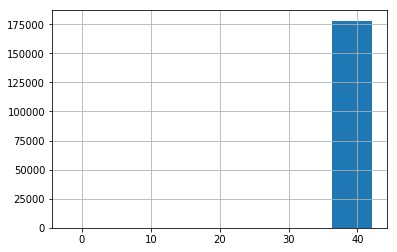

In [37]:
destination_latitute_bin,label = get_clustering_bins(pd.Series(all_bins_destination_latitute[0]), quantile=0.2, n_samples=35)
train_df.destination_latitute.hist(bins=destination_latitute_bin)
destination_latitute_bin

In [38]:
len(destination_latitute_bin) , train_df.destination_latitute.value_counts(bins=destination_latitute_bin)


(11, (36.246, 42.062]                178000
 (-2.1279999999999997, 4.715]        90
 (32.996, 36.246]                     0
 (29.855, 32.996]                     0
 (26.71, 29.855]                      0
 (23.567, 26.71]                      0
 (20.424, 23.567]                     0
 (17.284, 20.424]                     0
 (10.998, 17.284]                     0
 (4.715, 10.998]                      0
 Name: destination_latitute, dtype: int64)

In [39]:
train_df.destination_latitute.min(), train_df.destination_latitute.max(), train_df.destination_latitute.mean()

(-1.1268606, 41.0617744, 39.857049481556174)

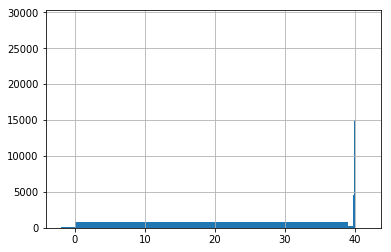

In [40]:
final_destination_latitute_bins = [-2, 0, 39, 39.7, 39.8, 39.82, 39.84, 39.86, 39.87, 39.88, 39.89, 39.9, 39.92, 39.94, 39.96, 39.98, 40, 40.1, 41.5 ]
train_df.destination_latitute.hist(bins=final_destination_latitute_bins)

In [41]:
len(final_destination_latitute_bins),train_df.destination_latitute.value_counts(bins=final_destination_latitute_bins)

(19, (39.84, 39.86]    28822
 (39.92, 39.94]    18922
 (39.9, 39.92]     18168
 (39.86, 39.87]    16906
 (39.87, 39.88]    15779
 (39.94, 39.96]    15073
 (39.88, 39.89]    14071
 (39.89, 39.9]     14003
 (39.7, 39.8]      11263
 (39.82, 39.84]    10770
 (39.8, 39.82]      4578
 (39.96, 39.98]     4435
 (39.98, 40.0]      3516
 (0.0, 39.0]         793
 (40.0, 40.1]        708
 (39.0, 39.7]        182
 (-2.001, 0.0]        90
 (40.1, 41.5]         11
 Name: destination_latitute, dtype: int64)

In [42]:
train_df2['destination_latitute_category'] = pd.cut(train_df.destination_latitute, final_destination_latitute_bins).cat.codes
train_df2.head(5).append(train_df2.tail(5))

,travel_id,travel_time,travel_day,travel_hour,source_latitute,source_longitute,destination_latitute,destination_longitute,source_latitude_category,source_longitute_category,destination_latitute_category
0,1278160345,962,Friday,20,39.885119,"32,8562758","39,8718379","32,8222507",18,5,8
1,1274461376,916,Tuesday,8,39.883463,"32,8335031","39,8912282","32,85792586",18,5,10
2,1278402853,1175,Saturday,2,39.916466,"32,7246981","39,9414644","32,7183841",18,4,13
3,1272398564,1630,Saturday,15,39.930718,"32,61985895","39,9023246","32,5240639",19,2,11
4,1279996323,561,Sunday,18,39.914876,"32,72881434","39,9307344","32,7187225",18,4,12
178085,1271716250,328,Friday,20,39.899967,"32,75756675","39,8954665","32,7700688",18,4,10
178086,1275289045,842,Wednesday,6,39.877181,"32,81464391","39,89683446","32,81631269",18,5,10
178087,1269676370,517,Wednesday,19,39.795645,"32,8746088","39,80247745","32,88210816",17,5,4
178088,1273331688,797,Sunday,18,39.865828,"32,8524761","39,8884061","32,8780075",18,5,9
178089,1291915508,919,Sunday,0,39.945700,"32,7596329","39,9541224","32,7690627",19,4,13


In [43]:
train_df['destination_longitute'] = train_df['destination_longitute'].str.replace(',','.')
train_df['destination_longitute'].values

array(['32.8222507', '32.85792586', '32.7183841', ..., '32.88210816',
       '32.8780075', '32.7690627'], dtype=object)

In [44]:
train_df['destination_longitute'] = train_df['destination_longitute'].astype(float)

In [45]:
all_bins_destination_longitute = []
all_bins_destination_longitute = get_columns_bins(train_df.destination_longitute)

Method : auto    - Running Time : 0:00:00.006045 - Number of bins : 7843  - Head : [3.7246258  3.72883347 3.73304113] - Tail : [36.71272117 36.71692883]
Method : fd      - Running Time : 0:00:00.004817 - Number of bins : 7843  - Head : [3.7246258  3.72883347 3.73304113] - Tail : [36.71272117 36.71692883]
Method : doane   - Running Time : 0:00:00.012708 - Number of bins : 32    - Head : [3.7246258  4.78902937 5.85343294] - Tail : [34.59232936 35.65673293]
Method : scott   - Running Time : 0:00:00.002543 - Number of bins : 752   - Head : [3.7246258  3.76856257 3.81249933] - Tail : [36.63326297 36.67719973]
Method : stone   - Running Time : 0:00:00.678154 - Number of bins : 378   - Head : [3.7246258 3.8121497 3.8996736] - Tail : [36.5460887 36.6336126]
Method : rice    - Running Time : 0:00:00.002423 - Number of bins : 114   - Head : [3.7246258  4.01663032 4.30863484] - Tail : [36.13712746 36.42913198]
Method : sturges - Running Time : 0:00:00.002279 - Number of bins : 20    - Head : [3.7

array([ 2.7246258 ,  4.15801532,  4.45255188,  4.88173374,  5.45818387,
        6.03042634,  6.46381586,  6.89299771,  7.46944785,  8.04169032,
        8.47507984,  8.90426169,  9.33765121,  9.76683306, 10.3432832 ,
       10.91552567, 11.34891519, 11.77809704, 12.35454718, 12.92678965,
       13.36017917, 13.78936102, 14.36581116, 14.93805363, 15.37144314,
       15.800625  , 16.23401452, 16.66319637, 17.2396465 , 17.81188898,
       18.24527849, 18.67446035, 19.25091048, 19.82315295, 20.25654247,
       20.68572432, 21.26217446, 21.83441693, 22.26780645, 22.6969883 ,
       23.13037782, 23.55955967, 24.13600981, 24.70825228, 25.1416418 ,
       25.57082365, 26.14727379, 26.71951626, 27.15290578, 27.58208763,
       28.15853777, 28.73078024, 29.16416975, 29.59335161, 30.02674113,
       30.45592298, 31.03237311, 31.60461559, 32.0380051 , 32.46718696,
       33.04363709, 33.61587956, 34.04926908, 34.47845093, 35.05490107,
       35.62714354, 36.17414002, 37.7211365 ])

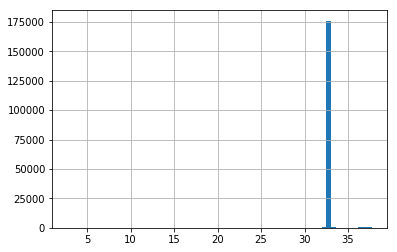

In [46]:
destination_longitute_bin,label = get_clustering_bins(pd.Series(all_bins_destination_longitute[0]), quantile=0.03, n_samples=120)
train_df.destination_longitute.hist(bins=destination_longitute_bin)
destination_longitute_bin

In [47]:
len(destination_longitute_bin),train_df.destination_longitute.value_counts(bins=destination_longitute_bin)

(68, (32.467, 33.044]    176010
 (36.174, 37.721]       793
 (32.038, 32.467]       760
 (33.044, 33.616]       436
 (2.724, 4.158]          90
 (30.027, 30.456]         1
 (33.616, 34.049]         0
 (10.343, 10.916]         0
 (16.663, 17.24]          0
 (16.234, 16.663]         0
 (15.801, 16.234]         0
 (15.371, 15.801]         0
 (14.938, 15.371]         0
 (14.366, 14.938]         0
 (13.789, 14.366]         0
 (13.36, 13.789]          0
 (12.927, 13.36]          0
 (12.355, 12.927]         0
 (11.778, 12.355]         0
 (11.349, 11.778]         0
 (10.916, 11.349]         0
 (9.767, 10.343]          0
 (17.812, 18.245]         0
 (9.338, 9.767]           0
 (8.904, 9.338]           0
 (8.475, 8.904]           0
 (8.042, 8.475]           0
 (7.469, 8.042]           0
 (6.893, 7.469]           0
 (6.464, 6.893]           0
                      ...  
 (34.049, 34.478]         0
 (18.674, 19.251]         0
 (34.478, 35.055]         0
 (35.055, 35.627]         0
 (31.605, 32.038

In [48]:
train_df.destination_longitute.min(), train_df.destination_longitute.max(), train_df.destination_longitute.mean()

(3.7246258, 36.7211365, 32.77065309663002)

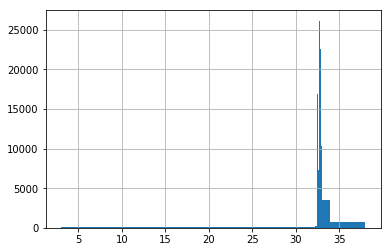

In [49]:
final_destination_longitute_bins = [3, 32.2, 32.4, 32.6, 32.65, 32.7, 32.73, 32.76, 32.8, 32.83, 32.86, 32.9, 33, 34, 38]
train_df.destination_longitute.hist(bins=final_destination_longitute_bins)

In [50]:
len(final_destination_longitute_bins),train_df.destination_longitute.value_counts(bins=final_destination_longitute_bins)

(15, (32.73, 32.76]    26145
 (32.76, 32.8]     24948
 (32.8, 32.83]     23906
 (32.83, 32.86]    22629
 (32.7, 32.73]     19834
 (32.4, 32.6]      16849
 (32.86, 32.9]     13166
 (32.9, 33.0]      10291
 (32.65, 32.7]      8515
 (32.6, 32.65]      7275
 (33.0, 34.0]       3447
 (34.0, 38.0]        793
 (32.2, 32.4]        201
 (2.999, 32.2]        91
 Name: destination_longitute, dtype: int64)

In [51]:
train_df2['destination_longitute_category'] = pd.cut(train_df.destination_longitute, final_destination_longitute_bins).cat.codes
train_df2.head(5).append(train_df2.tail(5))

,travel_id,travel_time,travel_day,travel_hour,source_latitute,source_longitute,destination_latitute,destination_longitute,source_latitude_category,source_longitute_category,destination_latitute_category,destination_longitute_category
0,1278160345,962,Friday,20,39.885119,"32,8562758","39,8718379","32,8222507",18,5,8,8
1,1274461376,916,Tuesday,8,39.883463,"32,8335031","39,8912282","32,85792586",18,5,10,9
2,1278402853,1175,Saturday,2,39.916466,"32,7246981","39,9414644","32,7183841",18,4,13,5
3,1272398564,1630,Saturday,15,39.930718,"32,61985895","39,9023246","32,5240639",19,2,11,2
4,1279996323,561,Sunday,18,39.914876,"32,72881434","39,9307344","32,7187225",18,4,12,5
178085,1271716250,328,Friday,20,39.899967,"32,75756675","39,8954665","32,7700688",18,4,10,7
178086,1275289045,842,Wednesday,6,39.877181,"32,81464391","39,89683446","32,81631269",18,5,10,8
178087,1269676370,517,Wednesday,19,39.795645,"32,8746088","39,80247745","32,88210816",17,5,4,10
178088,1273331688,797,Sunday,18,39.865828,"32,8524761","39,8884061","32,8780075",18,5,9,10
178089,1291915508,919,Sunday,0,39.945700,"32,7596329","39,9541224","32,7690627",19,4,13,7


In [52]:
source_location_df = train_df2.copy()
destination_location_df = train_df2.copy()

In [53]:
train_df2['source_longitute'] = train_df2['source_longitute'].str.replace(',','.')
train_df2['source_longitute'].values

train_df2['source_longitute'] = train_df2['source_longitute'].astype(float)

In [54]:
train_df2['destination_latitute'] = train_df2['destination_latitute'].str.replace(',','.')
train_df2['destination_latitute'].values

train_df2['destination_latitute'] = train_df2['destination_latitute'].astype(float)

In [55]:
train_df2['destination_longitute'] = train_df2['destination_longitute'].str.replace(',','.')
train_df2['destination_longitute'].values

train_df2['destination_longitute'] = train_df2['destination_longitute'].astype(float)

In [56]:
#location_df = location_df.drop(columns=['travel_id', 'travel_time', 'travel_day', 'travel_hour'])
source_location_df = source_location_df.drop(columns=['travel_id', 'travel_time', 'travel_day', 'travel_hour','destination_latitute', 'destination_longitute', 'destination_latitute_category', 'destination_longitute_category'])
destination_location_df = destination_location_df.drop(columns=['travel_id', 'travel_time', 'travel_day', 'travel_hour', 'source_latitute', 'source_longitute', 'source_latitude_category', 'source_longitute_category'])

In [57]:
source_location_df.dtypes

source_latitute              float64
source_longitute              object
source_latitude_category        int8
source_longitute_category       int8
dtype: object

In [58]:
source_location_df['source_longitute'] = source_location_df['source_longitute'].str.replace(',','.')
source_location_df['source_longitute'].values
source_location_df['source_longitute'] = source_location_df['source_longitute'].astype(float)

In [59]:
source_location_df.head()

,source_latitute,source_longitute,source_latitude_category,source_longitute_category
0,39.885119,32.856276,18,5
1,39.883463,32.833503,18,5
2,39.916466,32.724698,18,4
3,39.930718,32.619859,19,2
4,39.914876,32.728814,18,4


In [60]:
destination_location_df['destination_latitute'] = destination_location_df['destination_latitute'].str.replace(',','.')
destination_location_df['destination_latitute'].values

destination_location_df['destination_latitute'] = destination_location_df['destination_latitute'].astype(float)

destination_location_df['destination_longitute'] = destination_location_df['destination_longitute'].str.replace(',','.')
destination_location_df['destination_longitute'].values

destination_location_df['destination_longitute'] = destination_location_df['destination_longitute'].astype(float)

In [61]:
destination_location_df.head()

,destination_latitute,destination_longitute,destination_latitute_category,destination_longitute_category
0,39.871838,32.822251,8,8
1,39.891228,32.857926,10,9
2,39.941464,32.718384,13,5
3,39.902325,32.524064,11,2
4,39.930734,32.718722,12,5


In [62]:
distortions = [] 
inertias = [] 
source_mapping1 = {} 
source_mapping2 = {}
destination_mapping1 = {} 
destination_mapping2 = {} 
K = range(1,20)

In [63]:
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(source_location_df) 
    kmeanModel.fit(source_location_df)     
      
    distortions.append(sum(np.min(cdist(source_location_df, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / source_location_df.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    source_mapping1[k] = sum(np.min(cdist(source_location_df, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / source_location_df.shape[0] 
    source_mapping2[k] = kmeanModel.inertia_ 

In [64]:
for key,val in source_mapping1.items(): 
	print(str(key)+' : '+str(val))

1 : 1.4696929616268015
2 : 1.2420217965112248
3 : 0.9000535030524554
4 : 0.7185640931271984
5 : 0.6166964066442623
6 : 0.5036044404417136
7 : 0.4299595578004079
8 : 0.35471506177380413
9 : 0.2555691792382945
10 : 0.2036784724522111
11 : 0.1784297788819927
12 : 0.15600110623547178
13 : 0.12436656339176975
14 : 0.10219764250017423
15 : 0.08569960162589789
16 : 0.07448341685167123
17 : 0.06725121312612357
18 : 0.05441500147404105
19 : 0.05091376709531624


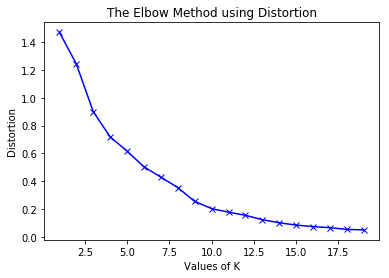

In [65]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 


In [66]:
for key,val in source_mapping2.items(): 
	print(str(key)+' : '+str(val))

1 : 2126825.969627183
2 : 378492.2741511906
3 : 186332.44854745566
4 : 120505.32164075418
5 : 89063.76303514566
6 : 65941.38845095155
7 : 50145.888345389074
8 : 38050.13610040603
9 : 28894.896585071223
10 : 22368.86826365553
11 : 18149.874311481974
12 : 15522.851338589582
13 : 11932.975165951273
14 : 9274.284625660348
15 : 7708.2073654160295
16 : 6293.052019160532
17 : 5546.7828414753
18 : 4294.028427537686
19 : 3456.743570909814


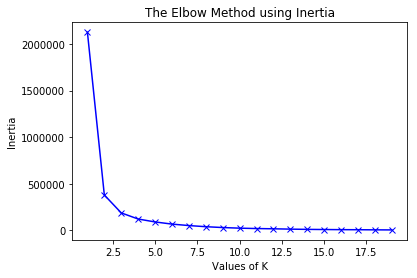

In [67]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 


In [68]:
now = datetime.now()
print(now)

K = 10
km = KMeans(n_clusters=K).fit(source_location_df)
print(km)

end = datetime.now()
print(end)
print(end-now)

2020-02-27 17:36:45.552805
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)
2020-02-27 17:36:47.232203
0:00:01.679398


In [69]:
distortions2 = [] 
inertias2 = [] 

L = range(1,20)

In [70]:
for l in L: 
    #Building and fitting the model 
    kmeanModel1 = KMeans(n_clusters=l).fit(destination_location_df) 
    kmeanModel1.fit(destination_location_df)     
      
    distortions2.append(sum(np.min(cdist(destination_location_df, kmeanModel1.cluster_centers_, 
                      'euclidean'),axis=1)) / destination_location_df.shape[0]) 
    inertias2.append(kmeanModel1.inertia_) 
  
    destination_mapping1[l] = sum(np.min(cdist(destination_location_df, kmeanModel1.cluster_centers_, 
                 'euclidean'),axis=1)) / destination_location_df.shape[0] 
    destination_mapping2[l] = kmeanModel1.inertia_ 

In [71]:
for key,val in destination_mapping1.items(): 
	print(str(key)+' : '+str(val))

1 : 3.8238415705007176
2 : 2.437476828668435
3 : 2.0663379951726735
4 : 1.7729073208280568
5 : 1.7254084523997517
6 : 1.460742321502419
7 : 1.3537324454821353
8 : 1.2232317125272403
9 : 1.1524091939277563
10 : 1.0682663333868803
11 : 1.0063212518725142
12 : 0.9471209429975173
13 : 0.9212938933742653
14 : 0.877948428321504
15 : 0.8574085199832842
16 : 0.821947235811251
17 : 0.7858269134586443
18 : 0.7725179226535639
19 : 0.729573964497455


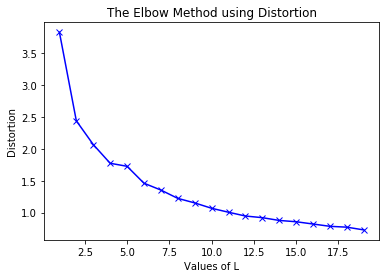

In [72]:
plt.plot(L, distortions2, 'bx-') 
plt.xlabel('Values of L') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 


In [73]:
for key,val in destination_mapping2.items(): 
	print(str(key)+' : '+str(val))

1 : 3330096.3644392006
2 : 1611253.2501198275
3 : 1206190.4669199574
4 : 905011.0334545576
5 : 677331.3891972312
6 : 497420.0441558533
7 : 412732.50002660876
8 : 344798.4140544088
9 : 297715.43087113136
10 : 259196.2132465952
11 : 237142.16243947062
12 : 211843.340621316
13 : 198314.3099279246
14 : 180544.88160797255
15 : 168702.9208508611
16 : 152013.2162913363
17 : 143328.269832171
18 : 134670.62985366085
19 : 123458.92994155252


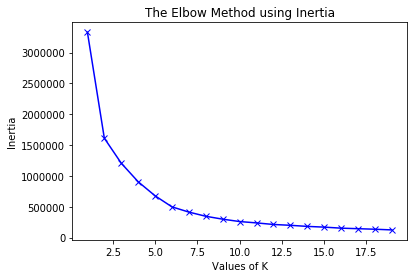

In [74]:
plt.plot(L, inertias2, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

In [75]:
now = datetime.now()
print(now)

L = 4
km2 = KMeans(n_clusters=L).fit(destination_location_df)
print(km2)

end = datetime.now()
print(end)
print(end-now)

2020-02-27 17:38:01.237274
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)
2020-02-27 17:38:02.310698
0:00:01.073424


In [76]:
train_df2['source_location_cluster'] = km.labels_
train_df2['destination_location_cluster'] = km2.labels_


In [77]:
train_df2.head(10)

,travel_id,travel_time,travel_day,travel_hour,source_latitute,source_longitute,destination_latitute,destination_longitute,source_latitude_category,source_longitute_category,destination_latitute_category,destination_longitute_category,source_location_cluster,destination_location_cluster
0,1278160345,962,Friday,20,39.885119,32.856276,39.871838,32.822251,18,5,8,8,6,2
1,1274461376,916,Tuesday,8,39.883463,32.833503,39.891228,32.857926,18,5,10,9,6,2
2,1278402853,1175,Saturday,2,39.916466,32.724698,39.941464,32.718384,18,4,13,5,3,0
3,1272398564,1630,Saturday,15,39.930718,32.619859,39.902325,32.524064,19,2,11,2,0,3
4,1279996323,561,Sunday,18,39.914876,32.728814,39.930734,32.718722,18,4,12,5,3,0
5,1279263882,1670,Saturday,19,39.873223,32.668740,39.866425,32.600397,18,3,7,3,9,3
6,1286102719,362,Sunday,2,39.941819,32.620206,39.948514,32.607289,19,2,13,3,0,0
7,1286767924,1178,Monday,8,39.933400,32.716455,39.938480,32.753487,19,3,12,6,0,0
8,1280823318,1043,Monday,19,39.869159,32.596796,39.866107,32.552084,18,2,7,2,4,3
9,1276163525,705,Thursday,5,39.851219,32.851746,39.858495,32.814374,17,5,6,8,2,2


In [78]:
import math  
def calculateDistance(x1,y1,x2,y2):  
     dist = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)  
     return dist

In [79]:
train_df2.dtypes

travel_id                           int64
travel_time                        object
travel_day                         object
travel_hour                        object
source_latitute                   float64
source_longitute                  float64
destination_latitute              float64
destination_longitute             float64
source_latitude_category             int8
source_longitute_category            int8
destination_latitute_category        int8
destination_longitute_category       int8
source_location_cluster             int32
destination_location_cluster        int32
dtype: object

In [80]:
train_df2['distance'] = calculateDistance(train_df2['source_latitute'], train_df2['source_longitute'], train_df2['destination_latitute'], train_df2['destination_longitute'])

In [81]:
train_df2.head(5)

,travel_id,travel_time,travel_day,travel_hour,source_latitute,source_longitute,destination_latitute,destination_longitute,source_latitude_category,source_longitute_category,destination_latitute_category,destination_longitute_category,source_location_cluster,destination_location_cluster,distance
0,1278160345,962,Friday,20,39.885119,32.856276,39.871838,32.822251,18,5,8,8,6,2,0.036525
1,1274461376,916,Tuesday,8,39.883463,32.833503,39.891228,32.857926,18,5,10,9,6,2,0.025627
2,1278402853,1175,Saturday,2,39.916466,32.724698,39.941464,32.718384,18,4,13,5,3,0,0.025783
3,1272398564,1630,Saturday,15,39.930718,32.619859,39.902325,32.524064,19,2,11,2,0,3,0.099914
4,1279996323,561,Sunday,18,39.914876,32.728814,39.930734,32.718722,18,4,12,5,3,0,0.018797


In [82]:
train_df2.dtypes

travel_id                           int64
travel_time                        object
travel_day                         object
travel_hour                        object
source_latitute                   float64
source_longitute                  float64
destination_latitute              float64
destination_longitute             float64
source_latitude_category             int8
source_longitute_category            int8
destination_latitute_category        int8
destination_longitute_category       int8
source_location_cluster             int32
destination_location_cluster        int32
distance                          float64
dtype: object

In [83]:
train_df2 = pd.concat([train_df2.drop(['travel_day'], axis=1), pd.get_dummies(train_df2.travel_day)], axis=1)

In [84]:
train_df2.head(5)

,travel_id,travel_time,travel_hour,source_latitute,source_longitute,destination_latitute,destination_longitute,source_latitude_category,source_longitute_category,destination_latitute_category,...,source_location_cluster,destination_location_cluster,distance,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,1278160345,962,20,39.885119,32.856276,39.871838,32.822251,18,5,8,...,6,2,0.036525,1,0,0,0,0,0,0
1,1274461376,916,8,39.883463,32.833503,39.891228,32.857926,18,5,10,...,6,2,0.025627,0,0,0,0,0,1,0
2,1278402853,1175,2,39.916466,32.724698,39.941464,32.718384,18,4,13,...,3,0,0.025783,0,0,1,0,0,0,0
3,1272398564,1630,15,39.930718,32.619859,39.902325,32.524064,19,2,11,...,0,3,0.099914,0,0,1,0,0,0,0
4,1279996323,561,18,39.914876,32.728814,39.930734,32.718722,18,4,12,...,3,0,0.018797,0,0,0,1,0,0,0


In [85]:
train_df2['travel_hour'] = train_df2['travel_hour'].astype(int)

In [86]:
train_df2.travel_hour.min(), train_df2.travel_hour.max()

(0, 23)

In [87]:
train_df2.dtypes

travel_id                           int64
travel_time                        object
travel_hour                         int64
source_latitute                   float64
source_longitute                  float64
destination_latitute              float64
destination_longitute             float64
source_latitude_category             int8
source_longitute_category            int8
destination_latitute_category        int8
destination_longitute_category       int8
source_location_cluster             int32
destination_location_cluster        int32
distance                          float64
Friday                              uint8
Monday                              uint8
Saturday                            uint8
Sunday                              uint8
Thursday                            uint8
Tuesday                             uint8
Wednesday                           uint8
dtype: object

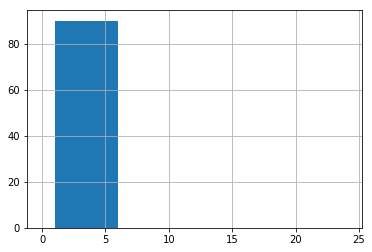

In [88]:
travel_hour_bins = [0, 1, 6, 7, 8, 9, 12, 13, 14, 16, 17, 18, 19, 22, 24]

train_df2.destination_longitute.hist(bins=travel_hour_bins)

In [89]:
len(travel_hour_bins),train_df2.travel_hour.value_counts(bins=travel_hour_bins)

(15, (9.0, 12.0]      25615
 (19.0, 22.0]     22690
 (7.0, 8.0]       19141
 (8.0, 9.0]       14896
 (14.0, 16.0]     14747
 (18.0, 19.0]     11380
 (17.0, 18.0]     10995
 (1.0, 6.0]       10638
 (6.0, 7.0]       10005
 (12.0, 13.0]      8510
 (-0.001, 1.0]     8471
 (16.0, 17.0]      8093
 (13.0, 14.0]      6738
 (22.0, 24.0]      6171
 Name: travel_hour, dtype: int64)

In [90]:
train_df2['travel_hour_category'] = pd.cut(train_df2.travel_hour, travel_hour_bins).cat.codes
train_df2.head(5).append(train_df2.tail(5))

,travel_id,travel_time,travel_hour,source_latitute,source_longitute,destination_latitute,destination_longitute,source_latitude_category,source_longitute_category,destination_latitute_category,...,destination_location_cluster,distance,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,travel_hour_category
0,1278160345,962,20,39.885119,32.856276,39.871838,32.822251,18,5,8,...,2,0.036525,1,0,0,0,0,0,0,12
1,1274461376,916,8,39.883463,32.833503,39.891228,32.857926,18,5,10,...,2,0.025627,0,0,0,0,0,1,0,3
2,1278402853,1175,2,39.916466,32.724698,39.941464,32.718384,18,4,13,...,0,0.025783,0,0,1,0,0,0,0,1
3,1272398564,1630,15,39.930718,32.619859,39.902325,32.524064,19,2,11,...,3,0.099914,0,0,1,0,0,0,0,8
4,1279996323,561,18,39.914876,32.728814,39.930734,32.718722,18,4,12,...,0,0.018797,0,0,0,1,0,0,0,10
178085,1271716250,328,20,39.899967,32.757567,39.895466,32.770069,18,4,10,...,2,0.013287,1,0,0,0,0,0,0,12
178086,1275289045,842,6,39.877181,32.814644,39.896834,32.816313,18,5,10,...,2,0.019724,0,0,0,0,0,0,1,1
178087,1269676370,517,19,39.795645,32.874609,39.802477,32.882108,17,5,4,...,1,0.010145,0,0,0,0,0,0,1,11
178088,1273331688,797,18,39.865828,32.852476,39.888406,32.878008,18,5,9,...,2,0.034082,0,0,0,1,0,0,0,10
178089,1291915508,919,0,39.945700,32.759633,39.954122,32.769063,19,4,13,...,0,0.012643,0,0,0,1,0,0,0,-1


In [91]:
train_df2['additional1_travel_hour_category'] = train_df2['travel_hour_category']
train_df2['additional2_travel_hour_category'] = train_df2['travel_hour_category']
train_df2['additional3_travel_hour_category'] = train_df2['travel_hour_category']

In [92]:
train_df2.head(10)

,travel_id,travel_time,travel_hour,source_latitute,source_longitute,destination_latitute,destination_longitute,source_latitude_category,source_longitute_category,destination_latitute_category,...,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,travel_hour_category,additional1_travel_hour_category,additional2_travel_hour_category,additional3_travel_hour_category
0,1278160345,962,20,39.885119,32.856276,39.871838,32.822251,18,5,8,...,0,0,0,0,0,0,12,12,12,12
1,1274461376,916,8,39.883463,32.833503,39.891228,32.857926,18,5,10,...,0,0,0,0,1,0,3,3,3,3
2,1278402853,1175,2,39.916466,32.724698,39.941464,32.718384,18,4,13,...,0,1,0,0,0,0,1,1,1,1
3,1272398564,1630,15,39.930718,32.619859,39.902325,32.524064,19,2,11,...,0,1,0,0,0,0,8,8,8,8
4,1279996323,561,18,39.914876,32.728814,39.930734,32.718722,18,4,12,...,0,0,1,0,0,0,10,10,10,10
5,1279263882,1670,19,39.873223,32.668740,39.866425,32.600397,18,3,7,...,0,1,0,0,0,0,11,11,11,11
6,1286102719,362,2,39.941819,32.620206,39.948514,32.607289,19,2,13,...,0,0,1,0,0,0,1,1,1,1
7,1286767924,1178,8,39.933400,32.716455,39.938480,32.753487,19,3,12,...,1,0,0,0,0,0,3,3,3,3
8,1280823318,1043,19,39.869159,32.596796,39.866107,32.552084,18,2,7,...,1,0,0,0,0,0,11,11,11,11
9,1276163525,705,5,39.851219,32.851746,39.858495,32.814374,17,5,6,...,0,0,0,1,0,0,1,1,1,1


In [93]:
train_df2['additional1_distance'] = train_df2['distance']
train_df2['additional2_distance'] = train_df2['distance']
train_df2['additional3_distance'] = train_df2['distance']

In [94]:
train_df2.shape

(178090, 28)

In [95]:
import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, make_scorer
from sklearn.model_selection import train_test_split, validation_curve, GridSearchCV
from datetime import datetime

from sklearn.pipeline import make_pipeline

from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [96]:
#Define mape method
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [97]:
train_df2['travel_time'] = train_df2['travel_time'].astype(int)

In [98]:
train_df2.dtypes

travel_id                             int64
travel_time                           int64
travel_hour                           int64
source_latitute                     float64
source_longitute                    float64
destination_latitute                float64
destination_longitute               float64
source_latitude_category               int8
source_longitute_category              int8
destination_latitute_category          int8
destination_longitute_category         int8
source_location_cluster               int32
destination_location_cluster          int32
distance                            float64
Friday                                uint8
Monday                                uint8
Saturday                              uint8
Sunday                                uint8
Thursday                              uint8
Tuesday                               uint8
Wednesday                             uint8
travel_hour_category                   int8
additional1_travel_hour_category

In [99]:
#Calculate correlations
corr = train_df2.corr()
corr

,travel_id,travel_time,travel_hour,source_latitute,source_longitute,destination_latitute,destination_longitute,source_latitude_category,source_longitute_category,destination_latitute_category,...,Thursday,Tuesday,Wednesday,travel_hour_category,additional1_travel_hour_category,additional2_travel_hour_category,additional3_travel_hour_category,additional1_distance,additional2_distance,additional3_distance
travel_id,1.000000,-0.015877,0.073609,0.005211,-0.004560,-0.000068,-0.001993,0.006074,-0.004479,0.003828,...,-0.061285,0.006489,0.044742,0.069406,0.069406,0.069406,0.069406,0.000010,0.000010,0.000010
travel_time,-0.015877,1.000000,0.054904,0.029756,-0.026259,-0.016109,-0.029980,0.024078,-0.026893,0.030509,...,0.013739,-0.001526,0.002855,0.049717,0.049717,0.049717,0.049717,0.042395,0.042395,0.042395
travel_hour,0.073609,0.054904,1.000000,-0.010691,0.016195,-0.003114,0.004148,-0.012149,0.015930,-0.021261,...,-0.004023,-0.007326,-0.000617,0.990372,0.990372,0.990372,0.990372,-0.000285,-0.000285,-0.000285
source_latitute,0.005211,0.029756,-0.010691,1.000000,-0.876927,0.088030,-0.337202,0.978504,-0.870378,0.557225,...,0.002702,0.002255,-0.000748,-0.008539,-0.008539,-0.008539,-0.008539,0.000386,0.000386,0.000386
source_longitute,-0.004560,-0.026259,0.016195,-0.876927,1.000000,-0.082521,0.378965,-0.852526,0.995586,-0.311039,...,-0.001364,0.000282,0.002820,0.015337,0.015337,0.015337,0.015337,0.001095,0.001095,0.001095
destination_latitute,-0.000068,-0.016109,-0.003114,0.088030,-0.082521,1.000000,0.886079,0.085875,-0.082312,0.123975,...,0.000034,0.001642,0.002685,-0.002391,-0.002391,-0.002391,-0.002391,-0.994876,-0.994876,-0.994876
destination_longitute,-0.001993,-0.029980,0.004148,-0.337202,0.378965,0.886079,1.000000,-0.327871,0.377003,-0.067883,...,-0.000250,0.001369,0.003814,0.004426,0.004426,0.004426,0.004426,-0.921389,-0.921389,-0.921389
source_latitude_category,0.006074,0.024078,-0.012149,0.978504,-0.852526,0.085875,-0.327871,1.000000,-0.845908,0.553371,...,0.003159,0.001458,-0.001276,-0.010207,-0.010207,-0.010207,-0.010207,0.000213,0.000213,0.000213
source_longitute_category,-0.004479,-0.026893,0.015930,-0.870378,0.995586,-0.082312,0.377003,-0.845908,1.000000,-0.302196,...,-0.000793,0.001017,0.003456,0.015027,0.015027,0.015027,0.015027,0.001489,0.001489,0.001489
destination_latitute_category,0.003828,0.030509,-0.021261,0.557225,-0.311039,0.123975,-0.067883,0.553371,-0.302196,1.000000,...,0.000723,0.001943,0.001270,-0.016726,-0.016726,-0.016726,-0.016726,-0.063277,-0.063277,-0.063277


In [100]:
cr = corr.copy()

In [101]:
top_corr_columns = []

In [102]:
#Determine best correlate columns over 0.01
top_corr_columns = cr.loc[:, 'travel_time'][:-1]
best_accurate_columns = top_corr_columns[abs(top_corr_columns) > 0.01].sort_values(ascending=False)
len(best_accurate_columns)

25

In [103]:
best_accurate_columns

travel_time                         1.000000
travel_hour                         0.054904
additional3_travel_hour_category    0.049717
additional2_travel_hour_category    0.049717
additional1_travel_hour_category    0.049717
travel_hour_category                0.049717
additional2_distance                0.042395
distance                            0.042395
additional1_distance                0.042395
destination_latitute_category       0.030509
source_latitute                     0.029756
Friday                              0.025402
source_latitude_category            0.024078
source_location_cluster             0.016639
Saturday                            0.015685
Thursday                            0.013739
destination_location_cluster        0.010457
travel_id                          -0.015877
destination_latitute               -0.016109
Monday                             -0.018819
source_longitute                   -0.026259
source_longitute_category          -0.026893
destinatio

In [104]:
train_df3 = train_df2[best_accurate_columns.keys()]

In [105]:
pip install sns

Note: you may need to restart the kernel to use updated packages.


In [106]:
import seaborn as sns

count    178090.000000
mean       1089.282346
std         608.855162
min         155.000000
25%         681.000000
50%         948.000000
75%        1334.000000
max       10719.000000
Name: travel_time, dtype: float64


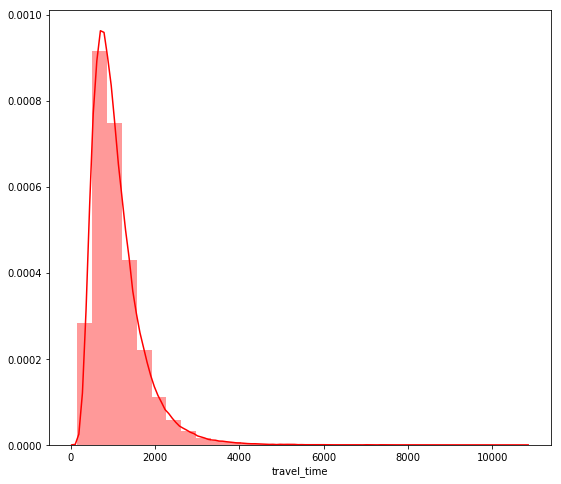

In [107]:
print(train_df2['travel_time'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(train_df2['travel_time'], color='r', bins=30, hist_kws={'alpha': 0.4});

In [108]:
# Prediction with two input variables

X = train_df3.copy()
X = X.drop(columns=['travel_time'])
#source_location_df = source_location_df.drop(columns=['travel_id', 'travel_time', 'travel_day', 'travel_hour','destination_latitute', 'destination_longitute', 'destination_latitute_category', 'destination_longitute_category'])
y = train_df3['travel_time']

In [109]:
X.head(2)

,travel_hour,additional3_travel_hour_category,additional2_travel_hour_category,additional1_travel_hour_category,travel_hour_category,additional2_distance,distance,additional1_distance,destination_latitute_category,source_latitute,...,Thursday,destination_location_cluster,travel_id,destination_latitute,Monday,source_longitute,source_longitute_category,destination_longitute,Sunday,destination_longitute_category
0,20,12,12,12,12,0.036525,0.036525,0.036525,8,39.885119,...,0,2,1278160345,39.871838,0,32.856276,5,32.822251,0,8
1,8,3,3,3,3,0.025627,0.025627,0.025627,10,39.883463,...,0,2,1274461376,39.891228,0,32.833503,5,32.857926,0,9


In [110]:
#Linear Regression Model
mae, mape = [], []
for i in range(1,10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    #X = X.fillna(X.mean()) #is this ok?
    #print("Tur : ", i)
    X_train = X_train.fillna(X_train.mean())
    X_test = X_test.fillna(X_test.mean())
    #print("TurV2 : ", i)
    lm = linear_model.LinearRegression()
    model_1 = lm.fit(X_train, y_train)
    #print("TurV3 : ", i)
    test_predictions = model_1.predict(X_test)
    #print("TurV4 : ", i)
    mae.append(mean_absolute_error(y_test, test_predictions))
    mape.append(mean_absolute_percentage_error(y_test, test_predictions))
    #print("TurV5 : ", i)

print("Test MAE:", np.mean(mae))
print("Test MAPE:", np.mean(mape))
print ("Intercept:", model_1.intercept_)
#combined = np.vstack((important_columns, model_1.coef_)).T
combined = np.empty((0, len(model_1.coef_)), dtype='f')

print(combined)

Test MAE: 321.52751879294533
Test MAPE: 34.99550416242991
Intercept: -384435.70025410154
[]


In [111]:
#Polynomial linear regrassion
from sklearn.preprocessing import PolynomialFeatures

X = X.fillna(X.mean())
#print("burda")
poly = PolynomialFeatures(degree=2, include_bias=False)
#print("burdaaa")
X_train_transform = poly.fit_transform(X)


mae, mape = [], []
for i in range(1,10):
    X_train, X_test, y_train, y_test = train_test_split(X_train_transform, y, test_size=0.4)
    print(X_train.shape)
    print(y_train.shape)

    lm = linear_model.LinearRegression()
    model_4 = lm.fit(X_train, y_train)
    test_predictions = model_4.predict(X_test)
    mae.append(mean_absolute_error(y_test, test_predictions))
    mape.append(mean_absolute_percentage_error(y_test, test_predictions))

print("Test MAE:", np.mean(mae))
print("Test MAPE:", np.mean(mape))
print ("Intercept:", model_4.intercept_)
#print(X);

(106854, 324)
(106854,)
(106854, 324)
(106854,)
(106854, 324)
(106854,)
(106854, 324)
(106854,)
(106854, 324)
(106854,)
(106854, 324)
(106854,)
(106854, 324)
(106854,)
(106854, 324)
(106854,)
(106854, 324)
(106854,)
Test MAE: 325.13566791647
Test MAPE: 35.28916129120381
Intercept: -484619.8406569837


In [112]:
#Lasso linear Regression
mae, mape = [], []

for i in range(1,3):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
    print(X_train.shape)
    print(y_train.shape)
    
    predictor_cols = [col for col in X_train 
                  if col != 'travel_time']
    
    clf = linear_model.Lasso(alpha=1, max_iter=100000)
    model_6 = clf.fit(X_train[predictor_cols], y_train)
    test_predictions = model_6.predict(X_test[predictor_cols])
    
    mae.append(mean_absolute_error(y_test, test_predictions))
    mape.append(mean_absolute_percentage_error(y_test, test_predictions))

print("Test MAE:", np.mean(mae))
print("Test MAPE:", np.mean(mape))
print ("Intercept:", model_6.intercept_)
#print(X);

(106854, 24)
(106854,)
(106854, 24)
(106854,)
Test MAE: 325.9631406231873
Test MAPE: 36.18569895661699
Intercept: -365740.39725497714


In [113]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [114]:
#XGBRegressor Model
mae, mape = [], []
for i in range(1,10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
    print(X_train.shape)
    print(y_train.shape)
    #X = X.fillna(X.mean()) #is this ok?
    #X_train = X_train.fillna(X_train.mean())
    #X_test = X_test.fillna(X_test.mean())

    xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.9, learning_rate = 0.5, 
                              max_depth = 10, alpha = 10, n_estimators = 50)
    model_5 =xg_reg.fit(X_train,y_train)
    test_predictions = model_5.predict(X_test)
    
    mae.append(mean_absolute_error(y_test, test_predictions))
    mape.append(mean_absolute_percentage_error(y_test, test_predictions))

print("Test MAE:", np.mean(mae))
print("Test MAPE:", np.mean(mape))
#print ("Intercept:", model_5.intercept_)
#print(X);

(106854, 24)
(106854,)
(106854, 24)
(106854,)
(106854, 24)
(106854,)
(106854, 24)
(106854,)
(106854, 24)
(106854,)
(106854, 24)
(106854,)
(106854, 24)
(106854,)
(106854, 24)
(106854,)
(106854, 24)
(106854,)
Test MAE: 253.6861155408178
Test MAPE: 25.687232944700455


In [115]:
from sklearn.model_selection import learning_curve, GridSearchCV

In [ ]:
#GridSearch to determine best parameters
param_grid = {
    'n_estimators': [50, 200, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}
#print("Burda")
grid_search_model = GridSearchCV(estimator=model_5, param_grid=param_grid, cv=5, refit=True)
#print("Burdaa")
grid_search_model.fit(X, y)
#print("Burdaaa")
print(grid_search_model.best_estimator_)

In [116]:
#Set XGBRegressor parameters from gridsearchCV
final_xg_reg = xgb.XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0,
             importance_type='gain', learning_rate=0.5, max_delta_step=0,
             max_depth=10, max_features='auto', min_child_weight=1,
             missing=None, n_estimators=50, n_jobs=1, nthread=None,
             objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=None, silent=None, subsample=1,
             verbosity=1)

(XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bynode=1, colsample_bytree=0.9, gamma=0,
        importance_type='gain', learning_rate=0.5, max_delta_step=0,
        max_depth=10, max_features='auto', min_child_weight=1, missing=None,
        n_estimators=50, n_jobs=1, nthread=None, objective='reg:linear',
        random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
        seed=None, silent=None, subsample=1, verbosity=1),
 XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bynode=1, colsample_bytree=0.9, gamma=0,
        importance_type='gain', learning_rate=0.5, max_delta_step=0,
        max_depth=10, max_features='auto', min_child_weight=1, missing=None,
        n_estimators=50, n_jobs=1, nthread=None, objective='reg:linear',
        random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
        seed=None, silent=None, subsample=1, verbosity=1))

In [195]:
xgb_model =final_xg_reg.fit(X_train,y_train)
test_predictions = xgb_model.predict(X_test)
    
mae.append(mean_absolute_error(y_test, test_predictions))
mape.append(mean_absolute_percentage_error(y_test, test_predictions))

print("Test MAE:", np.mean(mae))
print("Test MAPE:", np.mean(mape))

[17:53:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 970 extra nodes, 0 pruned nodes, max_depth=10
[17:53:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1552 extra nodes, 0 pruned nodes, max_depth=10
[17:53:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1520 extra nodes, 0 pruned nodes, max_depth=10
[17:53:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1586 extra nodes, 0 pruned nodes, max_depth=10
[17:53:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1462 extra nodes, 0 pruned nodes, max_depth=10
[17:53:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1358 extra nodes, 0 pruned nodes, max_depth=10
[17:53:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1076 extra nodes, 0 pruned nodes, max_depth=10
[17:53:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 610 extra nodes, 0 pruned nodes, max_dep

In [118]:
pipe_tree = make_pipeline(DecisionTreeRegressor(random_state=1))

In [119]:
# make an array of depths to choose from 1 to 10
depths = np.arange(2, 4)
depths

array([2, 3])

In [120]:
#make an array of min_sample_size to choose from 5 to 10
min_samples_split = np.arange(2,4)
min_samples_split

array([2, 3])

In [121]:
#make an array of min_samples_leaf to choose from 1 to 200
num_leafs = [5, 10, 50, 100]

In [122]:
dt_param_grid = [{'decisiontreeregressor__max_depth':depths,
              'decisiontreeregressor__min_samples_split':min_samples_split,
               'decisiontreeregressor__min_samples_leaf':num_leafs}]

In [123]:
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [124]:
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

In [125]:
gs = GridSearchCV(estimator=pipe_tree, param_grid=dt_param_grid, scoring=rmse_scorer, cv=10)

In [126]:
X_train_and_validate, X_test, y_train_and_validate, y_test = train_test_split(
    X, y, test_size = 0.30, random_state = 1
)

In [194]:
now = datetime.now()
print(now)
gs = gs.fit(X_train_and_validate, y_train_and_validate)
end = datetime.now()
print(end)
print(end-now)

2020-02-27 16:01:55.616648
2020-02-27 16:02:41.413270
0:00:45.796622


In [195]:
print(-gs.best_score_)

456.21315272284


In [196]:
best_params_ = gs.best_params_
best_params_

{'decisiontreeregressor__max_depth': 3,
 'decisiontreeregressor__min_samples_leaf': 5,
 'decisiontreeregressor__min_samples_split': 2}

In [197]:
best_dtr_model = gs.best_estimator_

In [198]:
print(gs.best_estimator_)

Pipeline(memory=None,
     steps=[('decisiontreeregressor', DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best'))])


In [127]:
final_dtr_model = DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')

In [128]:
dtr_model =final_dtr_model.fit(X_train,y_train)
test_predictions = dtr_model.predict(X_test)
    
mae.append(mean_absolute_error(y_test, test_predictions))
mape.append(mean_absolute_percentage_error(y_test, test_predictions))

print("Test MAE:", np.mean(mae))
print("Test MAPE:", np.mean(mape))

Test MAE: 259.026751845929
Test MAPE: 26.329331005078416


In [ ]:
#Upload test from local to colabs area
uploaded = files.upload()

In [129]:
# Load estimate dataset
estimate_df = pd.read_fwf("estimate.txt", sep=" ", header=None)
#estimate_df.reset_index()
estimate_df.head(5).append(estimate_df.tail(5))

,0,1
0,1273716598,"Monday\t9\t39,95541479\t32,74967882\t39,953436..."
1,1278773183,"Saturday\t14\t39,88519384\t32,79207537\t39,894..."
2,1288180189,"Tuesday\t18\t39,88823416\t32,83952448\t39,8976..."
3,1283497517,"Thursday\t18\t39,8368727\t32,807655\t39,828773..."
4,1278710560,"Saturday\t13\t39,8621794\t32,6052958\t39,91099..."
12486,1282776916,"Thursday\t8\t39,99088385\t32,73331568\t39,9834..."
12487,1276198094,"Thursday\t8\t39,87284907\t32,78721688\t39,8592..."
12488,1276171241,"Thursday\t6\t40,0141268\t32,77051852\t39,98516..."
12489,1273242277,"Sunday\t15\t39,90535833\t32,60610888\t39,86391..."
12490,1275437144,"Wednesday\t10\t39,9191065\t32,6693165\t39,9385..."


In [130]:
estimate_df.shape

(12491, 2)

In [131]:
split_data_2 = estimate_df[1].str.split("\t")
data_2 = split_data_2.to_list()
names_2 = ["travel_day", "travel_hour", "source_latitute", "source_longitute", "destination_latitute", "destination_longitute"]
new_df_2 = pd.DataFrame(data_2, columns=names_2)
new_df_2.head(5)

,travel_day,travel_hour,source_latitute,source_longitute,destination_latitute,destination_longitute
0,Monday,9,"39,95541479","32,74967882","39,9534366","32,73633476"
1,Saturday,14,"39,88519384","32,79207537","39,8944911","32,8090758"
2,Tuesday,18,"39,88823416","32,83952448","39,8976332","32,8309648"
3,Thursday,18,"39,8368727","32,807655","39,8287739","32,8112283"
4,Saturday,13,"39,8621794","32,6052958","39,910998","32,5958411"


In [132]:
estimate_df.rename(columns={0: "travel_id"}, inplace= True)
estimate_df = estimate_df.drop(columns=[1])
estimate_df.head(5)

,travel_id
0,1273716598
1,1278773183
2,1288180189
3,1283497517
4,1278710560


In [133]:
estimate_df = pd.concat([estimate_df, new_df_2], axis=1)
estimate_df.head(5)

,travel_id,travel_day,travel_hour,source_latitute,source_longitute,destination_latitute,destination_longitute
0,1273716598,Monday,9,"39,95541479","32,74967882","39,9534366","32,73633476"
1,1278773183,Saturday,14,"39,88519384","32,79207537","39,8944911","32,8090758"
2,1288180189,Tuesday,18,"39,88823416","32,83952448","39,8976332","32,8309648"
3,1283497517,Thursday,18,"39,8368727","32,807655","39,8287739","32,8112283"
4,1278710560,Saturday,13,"39,8621794","32,6052958","39,910998","32,5958411"


In [134]:
estimate_df['source_latitute'] = estimate_df['source_latitute'].str.replace(',','.')
estimate_df['source_latitute'].values

estimate_df['source_longitute'] = estimate_df['source_longitute'].str.replace(',','.')
estimate_df['source_longitute'].values

estimate_df['destination_latitute'] = estimate_df['destination_latitute'].str.replace(',','.')
estimate_df['destination_latitute'].values

estimate_df['destination_longitute'] = estimate_df['destination_longitute'].str.replace(',','.')
estimate_df['destination_longitute'].values

array(['32.73633476', '32.8090758', '32.8309648', ..., '32.7636364',
       '32.5943807', '32.7336969'], dtype=object)

In [135]:
estimate_df.head(5)

,travel_id,travel_day,travel_hour,source_latitute,source_longitute,destination_latitute,destination_longitute
0,1273716598,Monday,9,39.95541479,32.74967882,39.9534366,32.73633476
1,1278773183,Saturday,14,39.88519384,32.79207537,39.8944911,32.8090758
2,1288180189,Tuesday,18,39.88823416,32.83952448,39.8976332,32.8309648
3,1283497517,Thursday,18,39.8368727,32.807655,39.8287739,32.8112283
4,1278710560,Saturday,13,39.8621794,32.6052958,39.910998,32.5958411


In [136]:
estimate_df.source_latitute.isnull

<bound method Series.isnull of 0        39.95541479
1        39.88519384
2        39.88823416
3         39.8368727
4         39.8621794
5         39.8625094
6         39.8529194
7        39.88729332
8         39.8523624
9        39.92875387
10        39.9099147
11       39.85820237
12       39.95474722
13       39.92453482
14        39.8440216
15        39.9177806
16       39.79045984
17         39.852376
18        39.9224294
19       39.89658453
20       39.96233465
21       39.92070635
22       39.95848562
23        39.8415794
24        39.9562022
25       39.96539785
26       39.89430334
27       39.93435228
28         39.898024
29       39.95532324
            ...     
12461     39.8910294
12462     39.8533894
12463    39.92169668
12464     39.8845394
12465    39.86177923
12466     39.7503933
12467     39.8668833
12468    39.84967159
12469     39.8386545
12470    39.94421865
12471    39.96480536
12472     39.9272894
12473    39.88403799
12474     39.7811305
12475    39.93809988
124

In [137]:
estimate_df.source_longitute.isnull

<bound method Series.isnull of 0        32.74967882
1        32.79207537
2        32.83952448
3          32.807655
4         32.6052958
5         32.7909758
6         32.7919658
7        32.81405651
8         32.8332984
9        32.61880228
10        32.6980657
11        32.7555429
12       32.69234011
13       32.70815584
14        32.8637483
15        32.7071288
16       33.01915398
17       32.81483576
18        32.7013658
19       32.76631853
20       32.75693438
21       32.70131463
22       32.75583384
23        32.8390958
24        32.7135848
25       32.75261614
26       32.55979464
27       32.74857434
28        32.5504474
29       32.73754809
            ...     
12461     32.7530558
12462     32.7704158
12463    32.72069475
12464     32.8198958
12465    32.88012812
12466      32.953566
12467    32.86490748
12468     32.8366774
12469     32.8307989
12470    32.72515032
12471     32.8244295
12472     32.7291058
12473    32.83808253
12474     33.0396487
12475    32.75175783
124

In [138]:
estimate_df.destination_latitute.isnull

<bound method Series.isnull of 0         39.9534366
1         39.8944911
2         39.8976332
3         39.8287739
4          39.910998
5         39.8837691
6         39.8492447
7         39.8509326
8         39.8857661
9         39.9221955
10        39.9447722
11       39.88026451
12        39.9406965
13        39.9176447
14        39.8386284
15        39.9151657
16        39.7810763
17        39.8717672
18        39.9364561
19        39.8784793
20        39.9428024
21        39.9249307
22        39.9544466
23        39.8323864
24        39.9327202
25        39.9591796
26        -1.1268606
27        39.9224763
28        39.9105662
29        39.8686151
            ...     
12461     39.8964478
12462     39.8407744
12463     39.9458136
12464    39.88094605
12465     39.8262475
12466    39.75353248
12467     39.8893238
12468      39.781731
12469     39.8414139
12470     39.9892545
12471       39.78133
12472    39.91567947
12473     39.8838215
12474     39.7853047
12475     39.9818834
124

In [139]:
estimate_df.destination_longitute.isnull

<bound method Series.isnull of 0        32.73633476
1         32.8090758
2         32.8309648
3         32.8112283
4         32.5958411
5         32.8083972
6         32.8043083
7         32.8379877
8         32.9223558
9         32.6100317
10        32.7280448
11       32.76280046
12         32.699159
13        32.7012433
14        32.8309388
15       32.73135994
16        33.0396868
17        32.8692091
18        32.7157559
19         32.794593
20        32.7277018
21         32.710545
22        32.7377399
23        32.8302219
24        32.7257942
25        32.7714144
26         3.7246258
27        32.7295341
28        32.5102798
29        32.7640182
            ...     
12461     32.7420566
12462     32.7892775
12463     32.7437396
12464    32.83653508
12465     32.8156572
12466    32.96639571
12467      32.869931
12468     33.0359635
12469     32.8309144
12470     32.7349761
12471     33.0391856
12472    32.73367049
12473     32.8147457
12474     32.8791729
12475     32.7329808
124

In [140]:
estimate_df.dtypes

travel_id                 int64
travel_day               object
travel_hour              object
source_latitute          object
source_longitute         object
destination_latitute     object
destination_longitute    object
dtype: object

In [141]:
train_df3.dtypes

travel_time                           int64
travel_hour                           int64
additional3_travel_hour_category       int8
additional2_travel_hour_category       int8
additional1_travel_hour_category       int8
travel_hour_category                   int8
additional2_distance                float64
distance                            float64
additional1_distance                float64
destination_latitute_category          int8
source_latitute                     float64
Friday                                uint8
source_latitude_category               int8
source_location_cluster               int32
Saturday                              uint8
Thursday                              uint8
destination_location_cluster          int32
travel_id                             int64
destination_latitute                float64
Monday                                uint8
source_longitute                    float64
source_longitute_category              int8
destination_longitute           

In [142]:
estimate_df['travel_hour'] = estimate_df['travel_hour'].astype(int)
estimate_df['source_latitute'] = estimate_df['source_latitute'].astype(float)
estimate_df['source_longitute'] = estimate_df['source_longitute'].astype(float)
estimate_df['destination_latitute'] = estimate_df['destination_latitute'].astype(float)
estimate_df['destination_longitute'] = estimate_df['destination_longitute'].astype(float)

In [143]:
all_bins_source_latitude = []
all_bins_source_latitude = get_columns_bins(estimate_df.source_latitute)

Method : auto    - Running Time : 0:00:00.002400 - Number of bins : 231   - Head : [38.74390509 38.74962315 38.75534121] - Tail : [40.04762328 40.05334134]
Method : fd      - Running Time : 0:00:00.001159 - Number of bins : 231   - Head : [38.74390509 38.74962315 38.75534121] - Tail : [40.04762328 40.05334134]
Method : doane   - Running Time : 0:00:00.001444 - Number of bins : 25    - Head : [38.74390509 38.79870319 38.85350128] - Tail : [39.94946321 40.0042613 ]
Method : scott   - Running Time : 0:00:00.000575 - Number of bins : 100   - Head : [38.74390509 38.75718948 38.77047386] - Tail : [40.03249063 40.04577501]
Method : stone   - Running Time : 0:00:00.018009 - Number of bins : 85    - Head : [38.74390509 38.75956169 38.77521829] - Tail : [40.0277462 40.0434028]
Method : rice    - Running Time : 0:00:00.000522 - Number of bins : 48    - Head : [38.74390509 38.7718871  38.7998691 ] - Tail : [40.00309539 40.03107739]
Method : sturges - Running Time : 0:00:00.000430 - Number of bins 

array([37.74390509, 38.82395796, 38.88685665, 38.94975533, 39.01265401,
       39.0755527 , 39.1212972 , 39.16704169, 39.22994038, 39.29283906,
       39.35573775, 39.40148224, 39.44722674, 39.51012543, 39.57302411,
       39.6359228 , 39.69882148, 39.74456598, 39.79031048, 39.85320916,
       39.91610784, 39.97900653, 41.0590594 ])

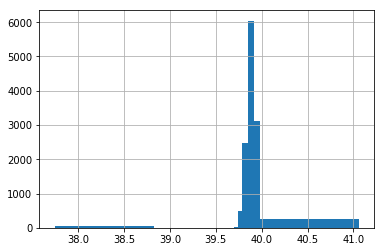

In [144]:
source_latitude_bin,label = get_clustering_bins(pd.Series(all_bins_source_latitude[0]), quantile=0.1, n_samples=20)
estimate_df.source_latitute.hist(bins=source_latitude_bin)
source_latitude_bin

In [145]:
len(source_latitude_bin) , estimate_df.source_latitute.value_counts(bins=source_latitude_bin)


(23, (39.853, 39.916]    6043
 (39.916, 39.979]    3127
 (39.79, 39.853]     2472
 (39.745, 39.79]      493
 (39.979, 41.059]     258
 (37.743, 38.824]      52
 (39.699, 39.745]      35
 (39.636, 39.699]       6
 (38.824, 38.887]       5
 (39.573, 39.636]       0
 (39.51, 39.573]        0
 (39.447, 39.51]        0
 (39.401, 39.447]       0
 (39.293, 39.356]       0
 (39.23, 39.293]        0
 (39.167, 39.23]        0
 (39.121, 39.167]       0
 (39.076, 39.121]       0
 (39.013, 39.076]       0
 (38.95, 39.013]        0
 (38.887, 38.95]        0
 (39.356, 39.401]       0
 Name: source_latitute, dtype: int64)

In [146]:
estimate_df2 = estimate_df.copy()

In [147]:
estimate_df2['source_latitude_category'] = pd.cut(estimate_df2.source_latitute, source_latitude_bin).cat.codes
estimate_df2.head(5).append(estimate_df2.tail(5))

,travel_id,travel_day,travel_hour,source_latitute,source_longitute,destination_latitute,destination_longitute,source_latitude_category
0,1273716598,Monday,9,39.955415,32.749679,39.953437,32.736335,20
1,1278773183,Saturday,14,39.885194,32.792075,39.894491,32.809076,19
2,1288180189,Tuesday,18,39.888234,32.839524,39.897633,32.830965,19
3,1283497517,Thursday,18,39.836873,32.807655,39.828774,32.811228,18
4,1278710560,Saturday,13,39.862179,32.605296,39.910998,32.595841,19
12486,1282776916,Thursday,8,39.990884,32.733316,39.983441,32.763673,21
12487,1276198094,Thursday,8,39.872849,32.787217,39.859223,32.822719,19
12488,1276171241,Thursday,6,40.014127,32.770519,39.985161,32.763636,21
12489,1273242277,Sunday,15,39.905358,32.606109,39.863914,32.594381,19
12490,1275437144,Wednesday,10,39.919106,32.669317,39.938505,32.733697,20


In [148]:
all_bins_source_longitute = []
all_bins_source_longitute = get_columns_bins(estimate_df.source_longitute)

Method : auto    - Running Time : 0:00:00.002064 - Number of bins : 412   - Head : [32.4159426  32.42621443 32.43648627] - Tail : [36.61712229 36.62739413]
Method : fd      - Running Time : 0:00:00.000921 - Number of bins : 412   - Head : [32.4159426  32.42621443 32.43648627] - Tail : [36.61712229 36.62739413]
Method : doane   - Running Time : 0:00:00.001401 - Number of bins : 25    - Head : [32.4159426  32.59184774 32.76775288] - Tail : [36.28585568 36.46176082]
Method : scott   - Running Time : 0:00:00.000625 - Number of bins : 103   - Head : [32.4159426  32.45733204 32.49872149] - Tail : [36.55488707 36.59627652]
Method : stone   - Running Time : 0:00:00.018275 - Number of bins : 106   - Head : [32.4159426  32.45614949 32.49635638] - Tail : [36.55725218 36.59745907]
Method : rice    - Running Time : 0:00:00.000672 - Number of bins : 48    - Head : [32.4159426 32.5057665 32.5955904] - Tail : [36.45801816 36.54784206]
Method : sturges - Running Time : 0:00:00.000537 - Number of bins :

array([31.4159426 , 32.45702993, 32.51866093, 32.59056376, 32.66246659,
       32.73436942, 32.80627225, 32.87817508, 32.95007792, 33.02198075,
       33.09388358, 33.16578641, 33.23768924, 33.30959207, 33.3814949 ,
       33.45339773, 33.52530056, 33.59720339, 33.68964989, 33.78209639,
       33.85399922, 33.92590205, 33.99780488, 34.06970771, 34.14161054,
       34.21351337, 34.2854162 , 34.35731904, 34.42922187, 34.5011247 ,
       34.57302753, 34.64493036, 34.71683319, 34.78873602, 34.86063885,
       34.95308535, 35.04553185, 35.11743468, 35.18933751, 35.26124034,
       35.33314317, 35.405046  , 35.47694883, 35.54885166, 35.62075449,
       35.69265732, 35.76456016, 35.83646299, 35.90836582, 35.98026865,
       36.05217148, 36.12407431, 36.21652081, 36.3089673 , 36.38087014,
       36.45277297, 36.5246758 , 36.57603496, 37.63766596])

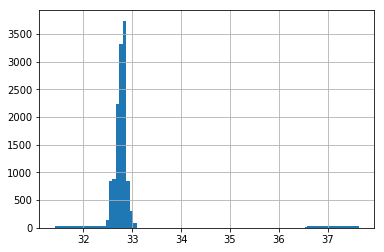

In [149]:
source_longitute_bin,label = get_clustering_bins(pd.Series(all_bins_source_longitute[0]), quantile=0.04, n_samples=70)
estimate_df.source_longitute.hist(bins=source_longitute_bin)
source_longitute_bin

In [150]:
len(source_longitute_bin) , estimate_df.source_longitute.value_counts(bins=source_longitute_bin)


(59, (32.806, 32.878]    3738
 (32.734, 32.806]    3321
 (32.662, 32.734]    2231
 (32.591, 32.662]     874
 (32.519, 32.591]     849
 (32.878, 32.95]      842
 (32.95, 33.022]      311
 (32.457, 32.519]     143
 (33.022, 33.094]      88
 (31.415, 32.457]      37
 (36.576, 37.638]      32
 (36.525, 36.576]      21
 (36.453, 36.525]       4
 (35.765, 35.836]       0
 (33.238, 33.31]        0
 (33.854, 33.926]       0
 (33.782, 33.854]       0
 (33.69, 33.782]        0
 (33.597, 33.69]        0
 (33.525, 33.597]       0
 (33.453, 33.525]       0
 (33.381, 33.453]       0
 (33.31, 33.381]        0
 (33.166, 33.238]       0
 (33.998, 34.07]        0
 (33.094, 33.166]       0
 (35.836, 35.908]       0
 (35.908, 35.98]        0
 (35.98, 36.052]        0
 (36.052, 36.124]       0
 (36.124, 36.217]       0
 (36.217, 36.309]       0
 (36.309, 36.381]       0
 (36.381, 36.453]       0
 (33.926, 33.998]       0
 (34.07, 34.142]        0
 (35.693, 35.765]       0
 (34.142, 34.214]       0
 (35.621

In [151]:
estimate_df2['source_longitute_category'] = pd.cut(estimate_df.source_longitute, source_longitute_bin).cat.codes
estimate_df2.head(5).append(estimate_df2.tail(5))

,travel_id,travel_day,travel_hour,source_latitute,source_longitute,destination_latitute,destination_longitute,source_latitude_category,source_longitute_category
0,1273716598,Monday,9,39.955415,32.749679,39.953437,32.736335,20,5
1,1278773183,Saturday,14,39.885194,32.792075,39.894491,32.809076,19,5
2,1288180189,Tuesday,18,39.888234,32.839524,39.897633,32.830965,19,6
3,1283497517,Thursday,18,39.836873,32.807655,39.828774,32.811228,18,6
4,1278710560,Saturday,13,39.862179,32.605296,39.910998,32.595841,19,3
12486,1282776916,Thursday,8,39.990884,32.733316,39.983441,32.763673,21,4
12487,1276198094,Thursday,8,39.872849,32.787217,39.859223,32.822719,19,5
12488,1276171241,Thursday,6,40.014127,32.770519,39.985161,32.763636,21,5
12489,1273242277,Sunday,15,39.905358,32.606109,39.863914,32.594381,19,3
12490,1275437144,Wednesday,10,39.919106,32.669317,39.938505,32.733697,20,4


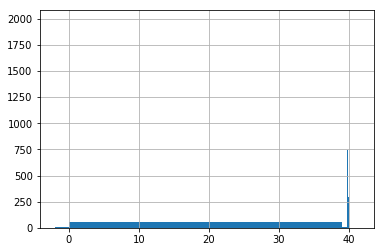

In [152]:
final_destination_latitute_bins = [-2, 0, 39, 39.7, 39.8, 39.82, 39.84, 39.86, 39.87, 39.88, 39.89, 39.9, 39.92, 39.94, 39.96, 39.98, 40, 40.1, 41.5 ]
estimate_df.destination_latitute.hist(bins=final_destination_latitute_bins)

In [153]:
len(final_destination_latitute_bins),estimate_df.destination_latitute.value_counts(bins=final_destination_latitute_bins)

(19, (39.84, 39.86]    1981
 (39.92, 39.94]    1333
 (39.9, 39.92]     1325
 (39.86, 39.87]    1188
 (39.87, 39.88]    1124
 (39.94, 39.96]    1033
 (39.88, 39.89]     994
 (39.89, 39.9]      985
 (39.7, 39.8]       804
 (39.82, 39.84]     741
 (39.8, 39.82]      301
 (39.96, 39.98]     299
 (39.98, 40.0]      251
 (0.0, 39.0]         57
 (40.0, 40.1]        57
 (39.0, 39.7]        11
 (-2.001, 0.0]        7
 (40.1, 41.5]         0
 Name: destination_latitute, dtype: int64)

In [154]:
estimate_df2['destination_latitute_category'] = pd.cut(estimate_df.destination_latitute, final_destination_latitute_bins).cat.codes
estimate_df2.head(5).append(estimate_df2.tail(5))

,travel_id,travel_day,travel_hour,source_latitute,source_longitute,destination_latitute,destination_longitute,source_latitude_category,source_longitute_category,destination_latitute_category
0,1273716598,Monday,9,39.955415,32.749679,39.953437,32.736335,20,5,13
1,1278773183,Saturday,14,39.885194,32.792075,39.894491,32.809076,19,5,10
2,1288180189,Tuesday,18,39.888234,32.839524,39.897633,32.830965,19,6,10
3,1283497517,Thursday,18,39.836873,32.807655,39.828774,32.811228,18,6,5
4,1278710560,Saturday,13,39.862179,32.605296,39.910998,32.595841,19,3,11
12486,1282776916,Thursday,8,39.990884,32.733316,39.983441,32.763673,21,4,15
12487,1276198094,Thursday,8,39.872849,32.787217,39.859223,32.822719,19,5,6
12488,1276171241,Thursday,6,40.014127,32.770519,39.985161,32.763636,21,5,15
12489,1273242277,Sunday,15,39.905358,32.606109,39.863914,32.594381,19,3,7
12490,1275437144,Wednesday,10,39.919106,32.669317,39.938505,32.733697,20,4,12


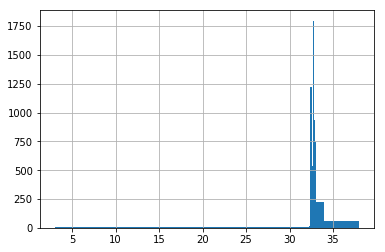

In [155]:
final_destination_longitute_bins = [3, 32.2, 32.4, 32.6, 32.65, 32.7, 32.73, 32.76, 32.8, 32.83, 32.86, 32.9, 33, 34, 38]
estimate_df.destination_longitute.hist(bins=final_destination_longitute_bins)

In [156]:
len(final_destination_longitute_bins),estimate_df.destination_longitute.value_counts(bins=final_destination_longitute_bins)

(15, (32.73, 32.76]    1797
 (32.76, 32.8]     1728
 (32.8, 32.83]     1717
 (32.83, 32.86]    1521
 (32.7, 32.73]     1385
 (32.4, 32.6]      1226
 (32.86, 32.9]      937
 (32.9, 33.0]       741
 (32.65, 32.7]      602
 (32.6, 32.65]      532
 (33.0, 34.0]       224
 (34.0, 38.0]        57
 (32.2, 32.4]        16
 (2.999, 32.2]        8
 Name: destination_longitute, dtype: int64)

In [157]:
estimate_df2['destination_longitute_category'] = pd.cut(estimate_df.destination_longitute, final_destination_longitute_bins).cat.codes
estimate_df2.head(5).append(estimate_df2.tail(5))

,travel_id,travel_day,travel_hour,source_latitute,source_longitute,destination_latitute,destination_longitute,source_latitude_category,source_longitute_category,destination_latitute_category,destination_longitute_category
0,1273716598,Monday,9,39.955415,32.749679,39.953437,32.736335,20,5,13,6
1,1278773183,Saturday,14,39.885194,32.792075,39.894491,32.809076,19,5,10,8
2,1288180189,Tuesday,18,39.888234,32.839524,39.897633,32.830965,19,6,10,9
3,1283497517,Thursday,18,39.836873,32.807655,39.828774,32.811228,18,6,5,8
4,1278710560,Saturday,13,39.862179,32.605296,39.910998,32.595841,19,3,11,2
12486,1282776916,Thursday,8,39.990884,32.733316,39.983441,32.763673,21,4,15,7
12487,1276198094,Thursday,8,39.872849,32.787217,39.859223,32.822719,19,5,6,8
12488,1276171241,Thursday,6,40.014127,32.770519,39.985161,32.763636,21,5,15,7
12489,1273242277,Sunday,15,39.905358,32.606109,39.863914,32.594381,19,3,7,2
12490,1275437144,Wednesday,10,39.919106,32.669317,39.938505,32.733697,20,4,12,6


In [158]:
estimate_source_location_df = estimate_df2.copy()
estimate_destination_location_df = estimate_df2.copy()

In [159]:
estimate_source_location_df = estimate_source_location_df.drop(columns=['travel_id', 'travel_day', 'travel_hour','destination_latitute', 'destination_longitute', 'destination_latitute_category', 'destination_longitute_category'])
estimate_destination_location_df = estimate_destination_location_df.drop(columns=['travel_id', 'travel_day', 'travel_hour', 'source_latitute', 'source_longitute', 'source_latitude_category', 'source_longitute_category'])

In [160]:
estimate_source_location_df.dtypes

source_latitute              float64
source_longitute             float64
source_latitude_category        int8
source_longitute_category       int8
dtype: object

In [161]:
estimate_destination_location_df.dtypes

destination_latitute              float64
destination_longitute             float64
destination_latitute_category        int8
destination_longitute_category       int8
dtype: object

In [162]:
es_distortions = [] 
es_inertias = [] 
es_source_mapping1 = {} 
es_source_mapping2 = {}
es_destination_mapping1 = {} 
es_destination_mapping2 = {} 
E1 = range(1,20)

In [163]:
for k in E1: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(estimate_source_location_df) 
    kmeanModel.fit(estimate_source_location_df)     
      
    es_distortions.append(sum(np.min(cdist(estimate_source_location_df, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / estimate_source_location_df.shape[0]) 
    es_inertias.append(kmeanModel.inertia_) 
  
    es_source_mapping1[k] = sum(np.min(cdist(estimate_source_location_df, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / estimate_source_location_df.shape[0] 
    es_source_mapping2[k] = kmeanModel.inertia_ 

In [164]:
for key,val in es_source_mapping1.items(): 
	print(str(key)+' : '+str(val))

1 : 1.703694483378607
2 : 1.442413967213751
3 : 0.9877335749442957
4 : 0.8008951767690098
5 : 0.7022554823765277
6 : 0.5831074702983823
7 : 0.48001944373724187
8 : 0.3864778544299283
9 : 0.33808062512252085
10 : 0.29219526260710366
11 : 0.220684993924808
12 : 0.2218818852579621
13 : 0.17358526272613958
14 : 0.14774351266170604
15 : 0.13068949900552992
16 : 0.11025942967332591
17 : 0.1002562523285461
18 : 0.08822513155931644
19 : 0.07731109110907933


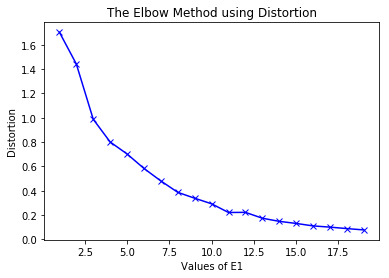

In [165]:
plt.plot(E1, es_distortions, 'bx-') 
plt.xlabel('Values of E1') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

In [166]:
for key,val in es_source_mapping2.items(): 
	print(str(key)+' : '+str(val))

1 : 208971.69637789024
2 : 37071.133242326185
3 : 16610.787318967094
4 : 10201.772469738375
5 : 7476.5038545575
6 : 5515.766696232811
7 : 4371.810427209229
8 : 3569.6299858864118
9 : 2921.402040551121
10 : 2515.4162825641874
11 : 1960.4723959617818
12 : 1795.1993106954983
13 : 1397.8918668401088
14 : 1147.2360876147732
15 : 932.8227538557327
16 : 767.1410491804505
17 : 656.5320393511687
18 : 566.1656890253198
19 : 480.0981046463758


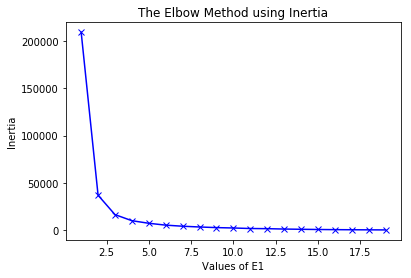

In [167]:
plt.plot(E1, es_inertias, 'bx-') 
plt.xlabel('Values of E1') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 


In [168]:
now = datetime.now()
print(now)

K = 3
es_km_1 = KMeans(n_clusters=K).fit(estimate_source_location_df)
print(es_km_1)

end = datetime.now()
print(end)
print(end-now)

2020-02-27 17:46:49.694134
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)
2020-02-27 17:46:49.758044
0:00:00.063910


In [169]:
es_distortions2 = [] 
es_inertias2 = [] 

E2 = range(1,20)

In [170]:
for l in E2: 
    #Building and fitting the model 
    kmeanModel1 = KMeans(n_clusters=l).fit(estimate_destination_location_df) 
    kmeanModel1.fit(estimate_destination_location_df)     
      
    es_distortions2.append(sum(np.min(cdist(estimate_destination_location_df, kmeanModel1.cluster_centers_, 
                      'euclidean'),axis=1)) / estimate_destination_location_df.shape[0]) 
    es_inertias2.append(kmeanModel1.inertia_) 
  
    es_destination_mapping1[l] = sum(np.min(cdist(estimate_destination_location_df, kmeanModel1.cluster_centers_, 
                 'euclidean'),axis=1)) / estimate_destination_location_df.shape[0] 
    es_destination_mapping2[l] = kmeanModel1.inertia_ 

In [171]:
for key,val in es_destination_mapping1.items(): 
	print(str(key)+' : '+str(val))

1 : 3.836504135094286
2 : 2.4573587979551
3 : 2.0768080869394554
4 : 1.76063534351178
5 : 1.7585970886796258
6 : 1.4685847101878118
7 : 1.3513753780928672
8 : 1.2230035423159895
9 : 1.135676697831799
10 : 1.076686076062664
11 : 1.021738987917086
12 : 0.9998563492123062
13 : 0.9240090156862039
14 : 0.8893870831218466
15 : 0.8813402614459648
16 : 0.8461658610456865
17 : 0.7955549079596157
18 : 0.7887747191410799
19 : 0.7328088931780113


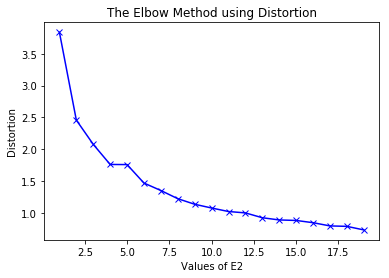

In [172]:
plt.plot(E2, es_distortions2, 'bx-') 
plt.xlabel('Values of E2') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

In [173]:
for key,val in es_destination_mapping2.items(): 
	print(str(key)+' : '+str(val))

1 : 236244.90337353532
2 : 115591.79331443715
3 : 86889.90971555744
4 : 65823.74402190158
5 : 47644.37789343763
6 : 35294.51696509577
7 : 28967.35468899752
8 : 24024.702448033837
9 : 20725.752730717948
10 : 18608.288551782967
11 : 16568.61211362716
12 : 15301.159461682795
13 : 14226.71796119481
14 : 12968.330721289993
15 : 12289.618518720763
16 : 11130.564431111437
17 : 10243.493637574667
18 : 9553.351531968656
19 : 8598.545887300255


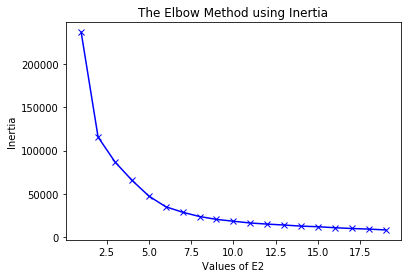

In [174]:
plt.plot(E2, es_inertias2, 'bx-') 
plt.xlabel('Values of E2') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

In [175]:
now = datetime.now()
print(now)

L = 4
es_km_2 = KMeans(n_clusters=L).fit(estimate_destination_location_df)
print(es_km_2)

end = datetime.now()
print(end)
print(end-now)

2020-02-27 17:47:00.542453
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)
2020-02-27 17:47:00.642523
0:00:00.100070


In [176]:
estimate_df2.shape, len(es_km_1.labels_)

((12491, 11), 12491)

In [177]:
estimate_df2['source_location_cluster'] = es_km_1.labels_
estimate_df2['destination_location_cluster'] = es_km_2.labels_


In [178]:
estimate_df2.head(5).append(estimate_df2.tail(5))

,travel_id,travel_day,travel_hour,source_latitute,source_longitute,destination_latitute,destination_longitute,source_latitude_category,source_longitute_category,destination_latitute_category,destination_longitute_category,source_location_cluster,destination_location_cluster
0,1273716598,Monday,9,39.955415,32.749679,39.953437,32.736335,20,5,13,6,2,1
1,1278773183,Saturday,14,39.885194,32.792075,39.894491,32.809076,19,5,10,8,0,0
2,1288180189,Tuesday,18,39.888234,32.839524,39.897633,32.830965,19,6,10,9,0,0
3,1283497517,Thursday,18,39.836873,32.807655,39.828774,32.811228,18,6,5,8,0,3
4,1278710560,Saturday,13,39.862179,32.605296,39.910998,32.595841,19,3,11,2,2,2
12486,1282776916,Thursday,8,39.990884,32.733316,39.983441,32.763673,21,4,15,7,2,1
12487,1276198094,Thursday,8,39.872849,32.787217,39.859223,32.822719,19,5,6,8,0,0
12488,1276171241,Thursday,6,40.014127,32.770519,39.985161,32.763636,21,5,15,7,2,1
12489,1273242277,Sunday,15,39.905358,32.606109,39.863914,32.594381,19,3,7,2,2,2
12490,1275437144,Wednesday,10,39.919106,32.669317,39.938505,32.733697,20,4,12,6,2,1


In [179]:
estimate_df2['distance'] = calculateDistance(estimate_df2['source_latitute'], estimate_df2['source_longitute'], estimate_df2['destination_latitute'], estimate_df2['destination_longitute'])

In [180]:
estimate_df2 = pd.concat([estimate_df2.drop(['travel_day'], axis=1), pd.get_dummies(estimate_df2.travel_day)], axis=1)

In [181]:
estimate_df2.head(5).append(estimate_df2.tail(5))

,travel_id,travel_hour,source_latitute,source_longitute,destination_latitute,destination_longitute,source_latitude_category,source_longitute_category,destination_latitute_category,destination_longitute_category,source_location_cluster,destination_location_cluster,distance,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,1273716598,9,39.955415,32.749679,39.953437,32.736335,20,5,13,6,2,1,0.013490,0,1,0,0,0,0,0
1,1278773183,14,39.885194,32.792075,39.894491,32.809076,19,5,10,8,0,0,0.019377,0,0,1,0,0,0,0
2,1288180189,18,39.888234,32.839524,39.897633,32.830965,19,6,10,9,0,0,0.012713,0,0,0,0,0,1,0
3,1283497517,18,39.836873,32.807655,39.828774,32.811228,18,6,5,8,0,3,0.008852,0,0,0,0,1,0,0
4,1278710560,13,39.862179,32.605296,39.910998,32.595841,19,3,11,2,2,2,0.049726,0,0,1,0,0,0,0
12486,1282776916,8,39.990884,32.733316,39.983441,32.763673,21,4,15,7,2,1,0.031256,0,0,0,0,1,0,0
12487,1276198094,8,39.872849,32.787217,39.859223,32.822719,19,5,6,8,0,0,0.038027,0,0,0,0,1,0,0
12488,1276171241,6,40.014127,32.770519,39.985161,32.763636,21,5,15,7,2,1,0.029772,0,0,0,0,1,0,0
12489,1273242277,15,39.905358,32.606109,39.863914,32.594381,19,3,7,2,2,2,0.043072,0,0,0,1,0,0,0
12490,1275437144,10,39.919106,32.669317,39.938505,32.733697,20,4,12,6,2,1,0.067239,0,0,0,0,0,0,1


In [182]:
estimate_df2['travel_hour'] = estimate_df2['travel_hour'].astype(int)

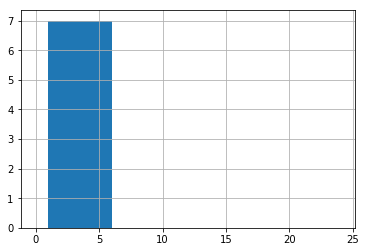

In [183]:
travel_hour_bins = [0, 1, 6, 7, 8, 9, 12, 13, 14, 16, 17, 18, 19, 22, 24]

estimate_df2.destination_longitute.hist(bins=travel_hour_bins)

In [184]:
len(travel_hour_bins),estimate_df2.travel_hour.value_counts(bins=travel_hour_bins)

(15, (9.0, 12.0]      1853
 (19.0, 22.0]     1558
 (7.0, 8.0]       1325
 (8.0, 9.0]       1048
 (14.0, 16.0]     1031
 (18.0, 19.0]      783
 (6.0, 7.0]        749
 (17.0, 18.0]      743
 (1.0, 6.0]        711
 (12.0, 13.0]      630
 (-0.001, 1.0]     598
 (16.0, 17.0]      564
 (13.0, 14.0]      465
 (22.0, 24.0]      433
 Name: travel_hour, dtype: int64)

In [185]:
estimate_df2['travel_hour_category'] = pd.cut(estimate_df2.travel_hour, travel_hour_bins).cat.codes
estimate_df2.head(5).append(estimate_df2.tail(5))

,travel_id,travel_hour,source_latitute,source_longitute,destination_latitute,destination_longitute,source_latitude_category,source_longitute_category,destination_latitute_category,destination_longitute_category,...,destination_location_cluster,distance,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,travel_hour_category
0,1273716598,9,39.955415,32.749679,39.953437,32.736335,20,5,13,6,...,1,0.013490,0,1,0,0,0,0,0,4
1,1278773183,14,39.885194,32.792075,39.894491,32.809076,19,5,10,8,...,0,0.019377,0,0,1,0,0,0,0,7
2,1288180189,18,39.888234,32.839524,39.897633,32.830965,19,6,10,9,...,0,0.012713,0,0,0,0,0,1,0,10
3,1283497517,18,39.836873,32.807655,39.828774,32.811228,18,6,5,8,...,3,0.008852,0,0,0,0,1,0,0,10
4,1278710560,13,39.862179,32.605296,39.910998,32.595841,19,3,11,2,...,2,0.049726,0,0,1,0,0,0,0,6
12486,1282776916,8,39.990884,32.733316,39.983441,32.763673,21,4,15,7,...,1,0.031256,0,0,0,0,1,0,0,3
12487,1276198094,8,39.872849,32.787217,39.859223,32.822719,19,5,6,8,...,0,0.038027,0,0,0,0,1,0,0,3
12488,1276171241,6,40.014127,32.770519,39.985161,32.763636,21,5,15,7,...,1,0.029772,0,0,0,0,1,0,0,1
12489,1273242277,15,39.905358,32.606109,39.863914,32.594381,19,3,7,2,...,2,0.043072,0,0,0,1,0,0,0,8
12490,1275437144,10,39.919106,32.669317,39.938505,32.733697,20,4,12,6,...,1,0.067239,0,0,0,0,0,0,1,5


In [186]:
estimate_df2['additional1_travel_hour_category'] = estimate_df2['travel_hour_category']
estimate_df2['additional2_travel_hour_category'] = estimate_df2['travel_hour_category']
estimate_df2['additional3_travel_hour_category'] = estimate_df2['travel_hour_category']

estimate_df2['additional1_distance'] = estimate_df2['distance']
estimate_df2['additional2_distance'] = estimate_df2['distance']
estimate_df2['additional3_distance'] = estimate_df2['distance']

In [187]:
estimate_df2.shape

(12491, 27)

In [188]:
estimate_df2.dtypes

travel_id                             int64
travel_hour                           int64
source_latitute                     float64
source_longitute                    float64
destination_latitute                float64
destination_longitute               float64
source_latitude_category               int8
source_longitute_category              int8
destination_latitute_category          int8
destination_longitute_category         int8
source_location_cluster               int32
destination_location_cluster          int32
distance                            float64
Friday                                uint8
Monday                                uint8
Saturday                              uint8
Sunday                                uint8
Thursday                              uint8
Tuesday                               uint8
Wednesday                             uint8
travel_hour_category                   int8
additional1_travel_hour_category       int8
additional2_travel_hour_category

In [189]:
best_accurate_columns.keys()

Index(['travel_time', 'travel_hour', 'additional3_travel_hour_category',
       'additional2_travel_hour_category', 'additional1_travel_hour_category',
       'travel_hour_category', 'additional2_distance', 'distance',
       'additional1_distance', 'destination_latitute_category',
       'source_latitute', 'Friday', 'source_latitude_category',
       'source_location_cluster', 'Saturday', 'Thursday',
       'destination_location_cluster', 'travel_id', 'destination_latitute',
       'Monday', 'source_longitute', 'source_longitute_category',
       'destination_longitute', 'Sunday', 'destination_longitute_category'],
      dtype='object')

In [191]:
best_estimate_accurate_columns = ['travel_hour', 'additional3_travel_hour_category',
       'additional2_travel_hour_category', 'additional1_travel_hour_category',
       'travel_hour_category', 'additional2_distance', 'distance',
       'additional1_distance', 'source_location_cluster',
       'destination_latitute_category', 'source_latitute', 'Friday',
       'source_latitude_category', 'Saturday', 'Thursday', 'travel_id',
       'destination_latitute', 'Monday', 'source_longitute',
       'source_longitute_category', 'destination_longitute',
       'destination_location_cluster', 'Sunday',
       'destination_longitute_category']

In [192]:
estimate_df3 = estimate_df2[best_estimate_accurate_columns]

In [193]:
estimate_df3.columns

Index(['travel_hour', 'additional3_travel_hour_category',
       'additional2_travel_hour_category', 'additional1_travel_hour_category',
       'travel_hour_category', 'additional2_distance', 'distance',
       'additional1_distance', 'source_location_cluster',
       'destination_latitute_category', 'source_latitute', 'Friday',
       'source_latitude_category', 'Saturday', 'Thursday', 'travel_id',
       'destination_latitute', 'Monday', 'source_longitute',
       'source_longitute_category', 'destination_longitute',
       'destination_location_cluster', 'Sunday',
       'destination_longitute_category'],
      dtype='object')

In [219]:
predictions = xgb_model.predict(estimate_df3[X_test.columns])
predictions

array([ 416.55328,  982.855  ,  742.0248 , ...,  785.5727 , 1488.792  ,
       1487.1781 ], dtype=float32)

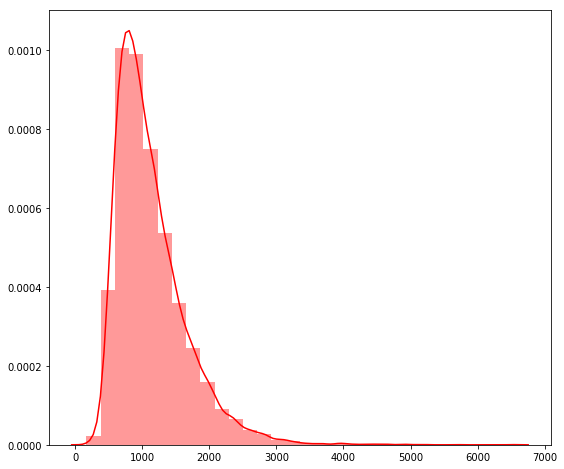

In [220]:
#Plot predictions
plt.figure(figsize=(9, 8))
sns.distplot(predictions, color='r', bins=30, hist_kws={'alpha': 0.4});

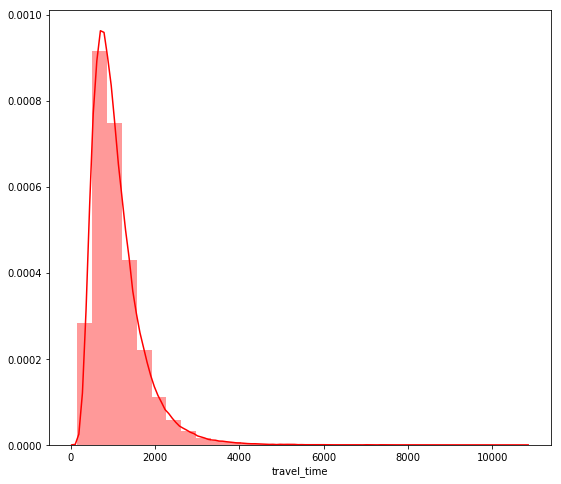

In [221]:
#Plot test data set
plt.figure(figsize=(9, 8))
sns.distplot(y, color='r', bins=30, hist_kws={'alpha': 0.4});

In [224]:
estimate_df.head(2)

,travel_id,travel_day,travel_hour,source_latitute,source_longitute,destination_latitute,destination_longitute
0,1273716598,Monday,9,39.955415,32.749679,39.953437,32.736335
1,1278773183,Saturday,14,39.885194,32.792075,39.894491,32.809076


In [222]:
#Create result dataframe
result_df = pd.DataFrame()

In [225]:
#Copy house Id from test data set
result_df['Id'] = estimate_df['travel_id'].astype(np.int64)

In [226]:
#Set result saleprice
result_df["predictions"] = predictions

In [228]:
result_df.head(2)

,Id,predictions
0,1273716598,416.553284
1,1278773183,982.854980


In [229]:
#Export dataframe as a csv
result_df.to_csv("prediction_results.csv", index=0)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:38:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:39:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:39:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:40:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:40:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:40:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:42:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:44:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:45:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:47:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:49:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:54:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:00:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:05:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:10:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:16:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:16:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:16:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:17:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:17:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:18:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:19:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:21:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:23:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:24:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:26:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:31:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:37:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:42:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:47:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:52:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:53:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:53:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:54:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:54:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:54:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:56:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:58:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:59:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:01:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:03:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:08:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:14:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:19:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:24:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[18:29:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0,
             importance_type='gain', learning_rate=0.5, max_delta_step=0,
             max_depth=10, max_features='auto', min_child_weight=1,
             missing=None, n_estimators=50, n_jobs=1, nthread=None,
             objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=None, silent=None, subsample=1,
             verbosity=1)
